<a href="https://colab.research.google.com/github/adasegroup/ML2020_seminars/blob/master/seminar18/seminar04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar 4. Time Series Forecasting 

1. Data preprocessing:

    1. Visualization of trends
    2. Filling missing values
    3. Preparation of training and test samples
    
2. Test for stationarity:

    1. Rolling characteristics
    2. Correlation analysis
    3. Testing hypotheses for stationarity of random process
    
3. Building a time series model:
    1. Bringing data to a stationarity one
    2. Holt-Winters model  of trend and seasonality 
    3. Validation of the time series model (evaluation metrics)    
    
4. Building an autoregression model and moving average model
    
    
5. Reducing the data dimension
    1. Singular spectral decomposition
    
6. Comparison of predictive models

7. Recurrent Neural Network

8. Long Short Term Memory

## Time series analysis is useful for...

- compressed **dynamics description** of the observed processes

- dynamics interpretation and **impulse response estimation**

- **forecasting** and simulation

- solving **optimal control** problems

## Problem statement of time series analysis

Building a time series model for the *current value* **of the endogenous** variable $y_t$

* from its *previous history* $y_{:t} = (y_{t-1}, y_{t-2}, \ldots)$

* *current value* **of the exogenous** variable $x_t$ and perhaps *their previous history* too


$$
    y_t \approx \text{model}\bigl( t,\, y_{:t},\, x_t,\, x_{:t} \bigr)
\,. $$

<!-- You can consider forecasting tasks several steps ahead of the current value, but the most commonly is using prediction one step ahead. -->

## Differences from other machine learning tasks

* Data is sequential:

  - the order of **time** must be strictly kept in order to save causality
  
* Great focus on **extrapolation**, i.e. a forecast for the future relative to the available sample
  
  - <span style="color:blue;">**IMPORTANT**</span> to make sure that <span style="color: blue;"> **there is no "leakage" of information "from the future"** </span> while generating features and building a model.
  
Therefore, features in the model can only depend on
* **endogenous** variable $y_{t-1}, y_{t-2}, \ldots$, available at the time of $t-1$ *inclusive*;
* **exogenous** variable $x_t, x_{t-1}, \ldots$, available at the time of $t$ *inclusive*;

In [0]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import mean_absolute_error

import pdb

import pandas as pd

import statsmodels as sm
import statsmodels.api

from tqdm import tqdm
import datetime
import seaborn as sns

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Plot results
def openfig(Figsize=(10, 6)):
    plt.figure(figsize=Figsize)


def savefig(filename):
    plt.savefig('{0}_{1}.png'.format(prefix_name, filename))
    plt.clf()
    
# Functions of creating synthetic time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Functions of creating feature and label
def t_window(x, size, shift=None, stride=1):
    try:
        nd = len(size)
    except TypeError:
        size = tuple(size for i in x.shape)
        nd = len(size)
    if nd != x.ndimension():
        raise ValueError("size has length {0} instead of "
                         "x.ndim which is {1}".format(len(size),
                                                      x.ndimension()))
    out_shape = tuple(xi-wi+1 for xi, wi in zip(x.shape, size)) + size
    if not all(i > 0 for i in out_shape):
        raise ValueError("size is bigger than input array along at "
                         "least one dimension")
    out_strides = x.stride() * 2
    return t.as_strided(x, out_shape, out_strides)


def t_apply(func, M):
    res = [func(m) for m in t.unbind(M, dim=0)]
    return res


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    '''
    series [t.tensor]: dataset
    '''
    if(isinstance(series, np.ndarray)):
        dataset = t.from_numpy(series)
    dataset = t_window(dataset, window_size + 1, shift=1)
    dataset = t_apply(lambda window: (window[:-1], window[-1:]), dataset)
    # batch_size: how many samples per batch to load (default: 1)
    dataset = DataLoader(dataset, shuffle=True, batch_size=batch_size)
    return dataset

In [0]:
t.manual_seed(1729)
np.random.seed(1729)
sns.set()

In [0]:
# Config of creating time series
num_days = 62 * 365 + 1
times = np.arange(num_days, dtype="float32")
series = trend(times, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 2

In [0]:
# Create the time series
series = baseline + trend(times, slope) + seasonality(times, period=365, amplitude=amplitude)

base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(num_days)]

In [0]:
# Update with noise
series += noise(series, noise_level, seed=42)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


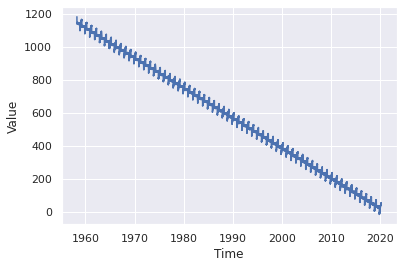

In [7]:
plot_series(date_list, series)

In [0]:
import pandas as pd
dataset = pd.DataFrame(dict(target = series, date = date_list))

In [9]:
dataset.head()

,target,date
0,50.993427,2020-03-22 01:19:20.865723
1,49.767544,2020-03-21 01:19:20.865723
2,51.371670,2020-03-20 01:19:20.865723
3,53.142731,2020-03-19 01:19:20.865723
4,49.636906,2020-03-18 01:19:20.865723


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22631 entries, 0 to 22630
Data columns (total 2 columns):
target    22631 non-null float32
date      22631 non-null datetime64[ns]
dtypes: datetime64[ns](1), float32(1)
memory usage: 265.3 KB


Create an index for the uploaded data: it is a **weekly periodic index**

We obtain data with a regular frequency.

In [0]:
dataset = dataset.set_index("date").to_period("W")

In [12]:
dataset.head()

,target
date,
2020-03-16/2020-03-22,50.993427
2020-03-16/2020-03-22,49.767544
2020-03-16/2020-03-22,51.371670
2020-03-16/2020-03-22,53.142731
2020-03-16/2020-03-22,49.636906


Plot the dynamics of the series

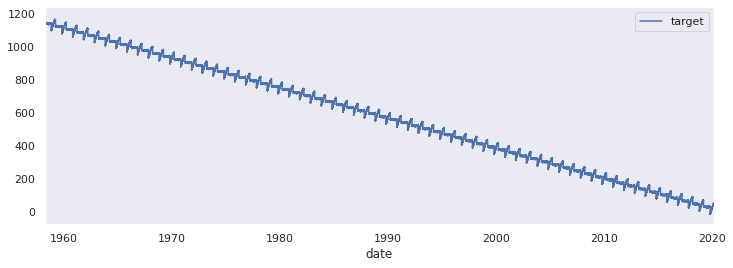

In [13]:
dataset.plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

Let's aggregate weekly data to monthly data

In [0]:
dataset = dataset.to_timestamp()

dataset = dataset.resample("M").mean()

In [15]:
dataset.head()

,target
date,
1958-04-30,1144.045410
1958-05-31,1142.955811
1958-06-30,1141.687378
1958-07-31,1141.454590
1958-08-31,1140.713379


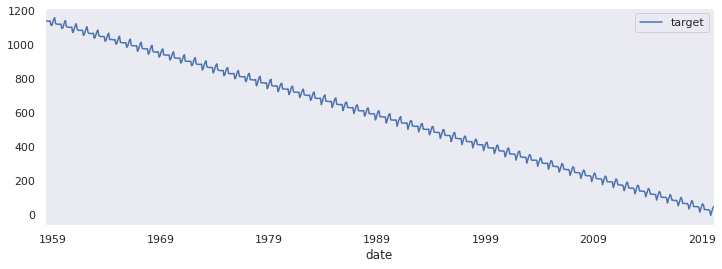

In [16]:
dataset.plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

In [17]:
dataset.shape

(744, 1)

Let's look through the summary statistics of the series:

In [18]:
print("Series {1}, Observations {0}".format(*dataset.shape))

dataset.describe().T.head()

Series 1, Observations 744


,count,mean,std,min,25%,50%,75%,max
target,744.0,582.825867,327.231506,-5.675568,301.579582,578.773102,867.098465,1160.902344


In [19]:
dataset

,target
date,
1958-04-30,1144.045410
1958-05-31,1142.955811
1958-06-30,1141.687378
1958-07-31,1141.454590
1958-08-31,1140.713379
...,...
2019-11-30,-5.675568
2019-12-31,12.543510
2020-01-31,32.068352


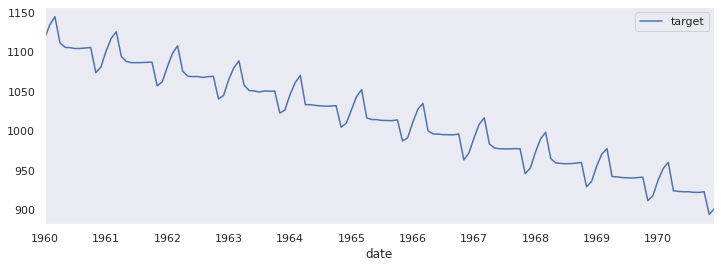

In [20]:
dataset.loc["1960":"1970"].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

#### В. Filling missing values

You can remove missing values in time series:

1) By filling the last known value:

   -  **+** doesn't look "into the future"
   
   -  **-** cannot fill the empty values at the beginning of a series
   
   -  **-** doesn't take into account peculiarities of the series
 
 Choose the `ffill` method to extrapolate the previous series values to the missing value. You can choose other standard methods, use the `Ctrl`+`Tab` to see the help
 
2) By interpolation of neighboring observable values:

  + **+** smoothes out the outliers in the values

  - **-** doesn't allow to fill empty values at the ends of series
  
  + **-** looks "into the future"
  
3) Exclude all missing values from the dataset:

  + **+** doesn't add distortion to values
  
  - **-** violates the regularity and relative periodicity

  - **-** reduce size of the dataset
  
4) Evaluate with a probabilistic model:

  + **+** filling in based on learned patterns
  
  - **-** need to specify the model and train it
  
5) Smooth with splines or a local kernel model:

  + **+** clearly taken into account the proximity of observations over time

  + **+** can increase the frequency of series observations ("resolution")

  + **+** can fill the gaps "on the edges"

  - **-** looks deep "into the future"
  
  - **-** requires kernel selection and an explicit model for extrapolation
  
The problem of looking into the future in methods 2 and 4 **can be ignored if the missing values are few**.

* <span style="color:blue;">**IMPORTANT**</span> If there are plenty of them, it is necessary to understand the origin of missing values.

In [0]:
maginfy_slice = slice("1960", "1967")

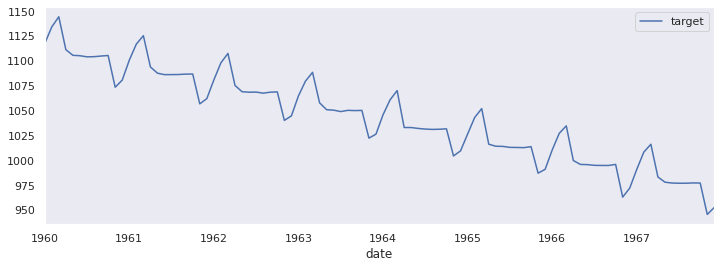

In [22]:
dataset_ff = dataset.fillna(method="ffill")
dataset_ff.loc[maginfy_slice].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

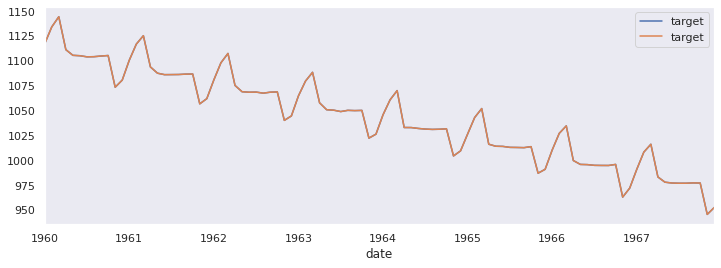

In [23]:
dataset_linterp = dataset.interpolate(method='linear')

dataset_pinterp = dataset.interpolate(method='polynomial', order=2)

ax = dataset_pinterp.loc[maginfy_slice].plot(figsize=(12, 4))

dataset_linterp.loc[maginfy_slice].plot(ax=ax)

plt.grid(which="major", axis="both")

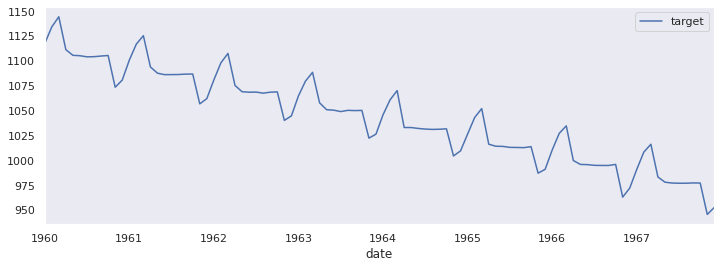

In [24]:
dataset_drop = dataset.dropna()

dataset_drop.loc[maginfy_slice].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

In [0]:
full_dataset = dataset_pinterp

 ### B. Preparation of training and test samples
 Let's prepare a training sample and a test sample

In [26]:
train_size = int((len(full_dataset.index)*0.95))

train = full_dataset.loc[:full_dataset.index[train_size]]
holdout = full_dataset.loc[full_dataset.index[train_size+1]:]
test_size = len(holdout)

print(len(train), len(holdout))

707 37


Make sure the parts don't overlap

In [27]:
pd.concat([
    train.tail(),
    holdout.head()
], axis=1)

,target,target
date,,
2016-10-31,72.796936,NaN
2016-11-30,50.590424,NaN
2016-12-31,66.915703,NaN
2017-01-31,86.475037,NaN
2017-02-28,101.056068,NaN
2017-03-31,NaN,91.277153
2017-04-30,NaN,65.857010
2017-05-31,NaN,65.516945
2017-06-30,NaN,65.170799


Explicitly save the intervals boundaries

In [28]:
holdout_slice = slice(*holdout.index[[0, -1]])

print("Training samples from {} to {}".format(*train.index[[0, -1]]))

print("Test samples from {} to {}".format(holdout_slice.start, holdout_slice.stop))

Training samples from 1958-04-30 00:00:00 to 2017-02-28 00:00:00
Test samples from 2017-03-31 00:00:00 to 2020-03-31 00:00:00


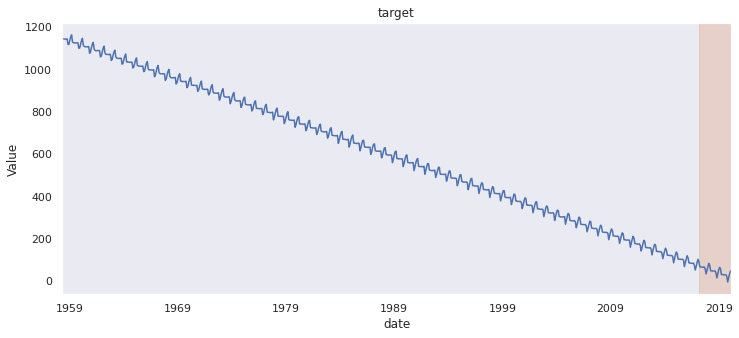

In [29]:
target_column = "target"

# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Period", ylabel="Value", title=target_column)

# plot the dynamics of the entire series
full_dataset[target_column].plot(ax=ax)

# emphasize the holdout interval
ax.axvspan(holdout_slice.start, holdout_slice.stop,
           color="C1", alpha=0.25, zorder=-99)

ax.grid(which="major", axis="both") ;



## 2. Examination of the processes stationarity:

**Stationarity** -- a useful property of the process $\{y_t\}_{t\geq0}$, meaning that
> probabilistic relationships in a set $(y_{t_1},\,\ldots,\,y_{t_m})$ exactly the same as 
in a set $(y_{t_1+s},\,\ldots,\,y_{t_m+s})$, for any shift $s \neq 0$.

* there are no **specific time moments** when statistical properties of observations change;


* patterns are stable over time and are determined only by the **observations indents relative to each other**;
    * mean, variance, and autocorrelations do not depend on the moment of time;

### Stationarity - property ... that doesn't exist

Stochastic processes occur in real problems **are almost always non-stationary**.

* the mean value depends on the time (trend in the dynamics)
    - sustained GDP growth
    - reduction of production in the oil well
    - dependence on external factors (exogenous variables)
* calendar event
    - state and religious holidays
* seasonal periodicity
    - intraday cycling of electricity consumption
    - seasonal temperatures
    - annual peaks of monthly inflation in January-February
* periods of conservative dynamics are replaced by periods of relatively high volatility
    - strong perturbations in financial markets during the crisis
* unpredictable structural shifts and market changes
    - political decision
    - hardware failure
    - hysteresis
    
Thus, great part of time series, especially economic, climate, and financial ones, are **non-stationary.**

#### Visualization and diagnostics of non-stationarity

Visualization in time series analysis allows to:

- to obtain a preliminary understanding of the correlation patterns

- choose an appropriate validation strategy

- estimate the presence of structural changes in the time series dynamics
    * outliers and breaks
    * periods of intense fluctuations and periods of smooth movements

- to diagnose non-stationarity: the presence of a trend, seasonality, etc.

###   А. Rolling characteristics

Rolling statistics of the series in the window with length $N$ let find changes over time

* **rolling mean:** mean value of recent interval
$$
    m_t = \frac1{N} \sum_{s=t-N+1}^t y_s
\,; $$

* **rolling standard deviation:** spread or volatility
$$
    s_t = \sqrt{s^2_t}
        \,, \quad
    s^2_t = \frac1{N-1} \sum_{s=t-N+1}^t (y_s - m_t)^2
\,; $$

Procedure for easily plotting diagnostics below.

In [0]:
def rolling_diagnostics(series, window=500):
    rolling = series.rolling(window)

    # create and customize the figures: top and bottom
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Rolling mean", xlabel="Date", ylabel="value")
    ax_bottom = fig.add_subplot(212, title="Rolling std",
                                sharex=ax_top, xlabel="Date", ylabel="std")

    # draw plots:
    # series and rolling mean
    rolling.mean().plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # rolling std
    rolling.std().plot(ax=ax_bottom)
    ax_bottom.grid(which="major", axis="both")

    fig.tight_layout()
    return fig

Using rolling statistics we can get an idea about the presense of a trend in dynamic.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

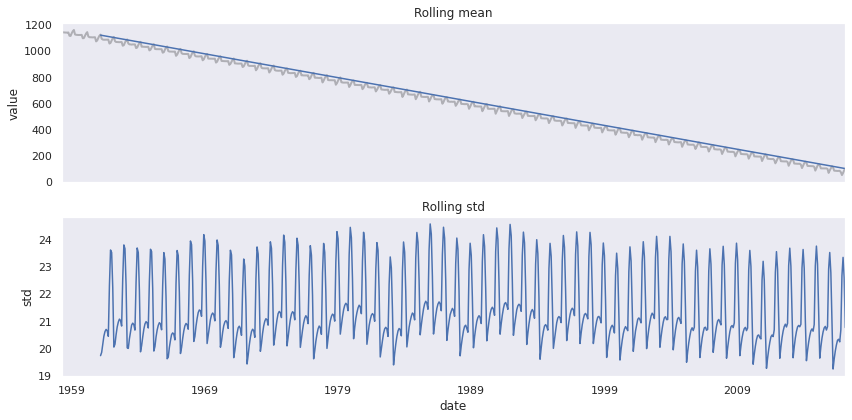

In [31]:
rolling_diagnostics(train[target_column], window=36);

###  Rough estimate of seasonality

Let's try explore seasonality, such as monthly or weekly.

* while evaluating seasonality, it is desirable to make seasonal correction relatively to the trend.

In [0]:
sm.api.nonparametric.lowess?

In [0]:
def monthly_seasonality_diagnostics(series, fraction=0.66, period="month"):

    # use nonparametric local linear regression for preliminary trend estimation
    trend = sm.api.nonparametric.lowess(series, np.r_[:len(series)],
                                        frac=fraction, it=5)

    # group by month and calculate the mean and std
    by = getattr(series.index, period, "month")
    season_groupby = (series - trend[:, 1]).groupby(by)
    seas_mean, seas_std = season_groupby.mean(), season_groupby.std()

    # create and customize the figures: top and bottom
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Trend", xlabel="Date")
    ax_bottom = fig.add_subplot(212, title="Seasonality", xlabel=period)

    # draw plots:
    # series and trend
    pd.Series(trend[:, 1], index=series.index).plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # seasonality and 90% normal confidence interval
    ax_bottom.plot(1 + np.r_[:len(seas_mean)], seas_mean, lw=2)
    ax_bottom.fill_between(1 + np.r_[:len(seas_mean)],
                           seas_mean - 1.96 * seas_std,
                           seas_mean + 1.96 * seas_std,
                           zorder=-10, color="C1", alpha=0.15)
    ax_bottom.grid(which="major", axis="both")


    fig.tight_layout()
    return fig

The graphs show that there is seasonal periodicity in the dynamics

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

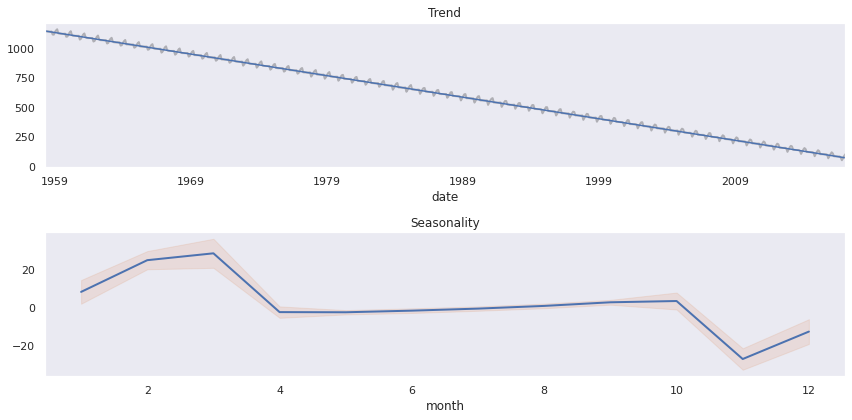

In [34]:
monthly_seasonality_diagnostics(train[target_column], fraction=0.33, period="month");

### B. Correlation analysis

#### Autocorrelation  and partial autocorrelation

These functions evaluate the effect of observing $h$ steps on the current observation, but do it in different ways:

* **autocorrelation** $\rho_h$ <!-- ($y_t \sim y_{t-h}$) -->
  - reflects the **aggregate** effect of $y_{t-h}$ on $y_t$ ** through** influence on all intermediate $y_{t-j}$, $j=1,\,...,\,h-1$
  
* **partial autocorrelation** $\phi_h$ <!-- ($y_t \sim y_{t-1}, \ldots, y_{t-h}$) -->
  - shows **pure** effect $y_{t-h}$ on $y_t$ **except** impact on the intermediate $y_{t-j}$, $j=1,\,...,\,h-1$

In [0]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [0]:
def correlation_diagnostics(series, lags=60):
    # create and customize the figures: left and right
    fig = plt.figure(figsize=(12, 3))
    ax_left, ax_right = fig.subplots(
        nrows=1, ncols=2, sharey=True, sharex=True,
        subplot_kw={"xlabel": "Lag", "ylim": (-1.1, 1.1)})

    # draw plots using function from statsmodels
    plot_acf(series, ax_left, lags=lags, zero=False, alpha=0.05,
             title="Sample Autocorrelation", marker=None)

    plot_pacf(series, ax_right, lags=lags, zero=False, alpha=0.05,
              title="Sample Partial Autocorrelation", marker=None)

    fig.tight_layout()
    return fig

Let's explore sample autocorrelations of our series

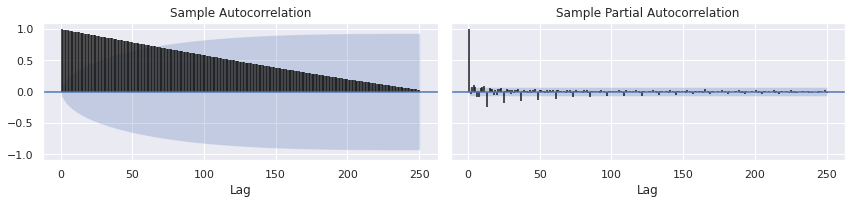

In [37]:
correlation_diagnostics(train[target_column], lags=250);

* on the *left plot* autocorrelation of small lags is close to $1.0$ and decreases quite slowly
* on the *right plot*, a statistically non-zero effect has an observation with a lag of 1

These are symptoms of the most typical type of non-stationarity -- presence of a dependency $y_t = y_{t-1} + \ldots$.

So, it seems that there is a strong dependence on the process history.

### C. Testing hypotheses for processes stationarity

#### Statistical diagnostics of non-stationarity
There are two types of trend in time series
* **determenistic trend** -- when noise or time deviations do not affect values in the long prospect 

* **stochastic trend** -- noise or unexpected shocks affect the entire future trajectory

For example, linear trends
\begin{aligned}
    & \text{Trend}
      & & \text{levels}
          & & \text{residuals}
        \\
    & \text{determenistic}
      & y_t
        &= y_1 + \delta \, t + \varepsilon_t
          & & y_t - y_{t-1} = \delta + \varepsilon_t-\varepsilon_{t-1}
    \,, \\
    & \text{stochastic}
      & y_t
        &= y_1 + \delta \, t + \sum_{s=1}^t \varepsilon_s
          & & y_t - y_{t-1} = \delta + \varepsilon_t
    \,,
\end{aligned}

#### KPSS

If suspect a **deterministic** linear trend, use the **KPSS test**: test the hypothesis $H_0\colon \sigma^2 = 0$ in the model


$$
    y_t = \alpha + \beta t + u_t + \nu_t
        \,, \quad
    u_t = u_{t-1} + \varepsilon_t
        \,, \quad
    \varepsilon_t \sim D(0, \sigma^2)
\,. $$

#### ADF

If suspect a **deterministic** linear trend, use the **KPSS test**: test the hypothesis $H_0\colon \sigma^2 = 0$ in the model

If suspect a **stochastic** trend, use the **Augmented Dickey-Fuller unit root test**: test the hypothesis $H_0\colon \gamma = 0$ in the model
$$
    \Delta y_t
        = \beta + \gamma y_{t-1}
            + \sum_{k=1}^{p-1} \phi_k \Delta y_{t-k}
            + \varepsilon_t
\,, $$
where $\Delta y_t = y_t - y_{t-1}$ -- first residual.

Alternatively, you can use the Phillips-Perron test.

<!-- [Four cases](https://stats.stackexchange.com/questions/239360/contradictory-results-of-adf-and-kpss-unit-root-tests/239367) --
<!--http://web.econ.ku.dk/metrics/Econometrics2_05_II/Slides/08_unitroottests_2pp.pdf-->

\* It is better, just in case, to take the first residual (there may be a high persistence).

** There can be anything: seasonality, heteroscedasticity, structural shifts, a weak but non-zero stochastic trend.

The procedure that returns text statistics and the corresponding $p$-value:

In [0]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

In [0]:
def stat_test_diagnostics(series):
    return {
        "ADF": adfuller(series, regression="ct")[:2],
        "KPSS": kpss(series, regression="c")[:2],
    }

In [40]:
stat_test_diagnostics(train[target_column])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


{'ADF': (-8.345171134200736, 1.1397803517538508e-11),
 'KPSS': (3.469011063449453, 0.01)}

All diagnostics in one procedure:

In [0]:
def diagnostics(series, window=250, fraction=0.25, lags=250):
    # rolling statistics
    rolling_diagnostics(series, window=window)
    plt.show()
    plt.close()

    # rough seasonality
    monthly_seasonality_diagnostics(series, fraction=fraction)
    plt.show()
    plt.close()

    # autocorrelations
    correlation_diagnostics(series, lags=lags)
    plt.show()
    plt.close()

    return stat_test_diagnostics(series)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

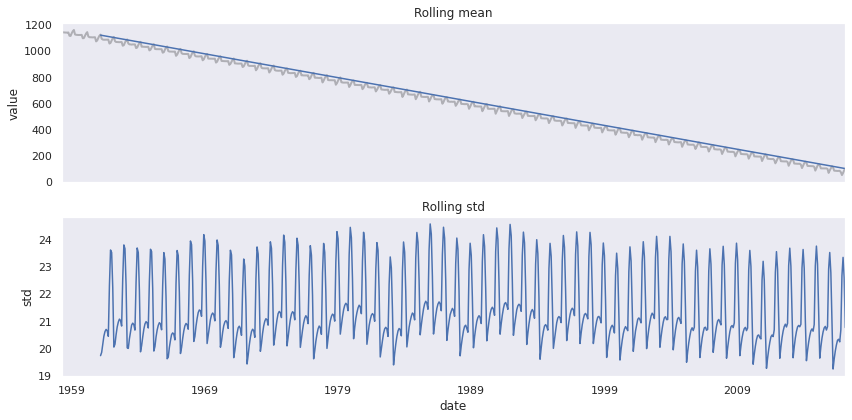

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

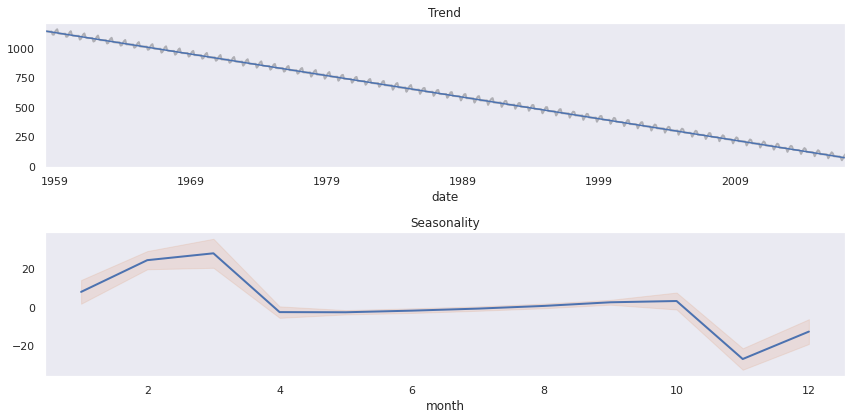

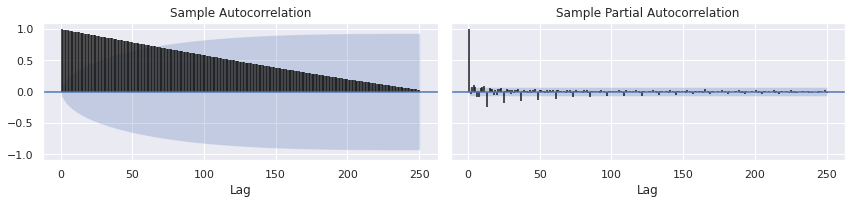

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


{'ADF': (-8.345171134200736, 1.1397803517538508e-11),
 'KPSS': (3.469011063449453, 0.01)}

In [42]:
diagnostics(train[target_column], window=36)

### Problem

It is very difficult to model series **without stationarity**
 * there are no stable invariant patterns suitable for modeling and forecasting
 
### What should we do?
In time series analysis, everything is as in optimization problems
* successfully solved problems of **convex ** programming
* but all interesting practical problems are **non-convex**

If **approximate** the series as close as possible to the stationary one, **taking into account the trend, seasonality and other spoiling factors**, we **can hope for** more or less successful **modeling and solving** application problems.

`I`. **Make time series stationary** using
  * transformations
    - $ y \mapsto \log{y} $, 
    - $ y \mapsto \frac{y^q - 1}{q} $, 
    - or $ y \mapsto \sqrt{y} $;
    - shift and scaling

  * taking consecutive or seasonal residuals  

  * extraction and subtraction of trends/seasonalities

  * identification of special dates or events
    - state and religious holidays
    - moments of equipment replacement
    - crossing the rock type border.

* test hypotheses about the type of trend and seasonality
    * **deterministic** -- it is enough to evaluate it and then subtract it
    * **stochastic** -- it is necessary to take consecutive / seasonal differences of the series
  * e.t.c.

<span style="color:blue;">**IMPORTANT**</span> inverse transformation should be applied to forecasts in **inverse** order!

`II`. **Estimate the model parameters**
  * Maximizing likelihood, minimizing the $L^2$ loss function or empirical risk, etc.
  * take into account the heteroscedasticity and autocorrelation effects

`III`. **Visualization of differences**
  * look at the dynamics of the series, autocorrelations and partial autocorrelations, moving statistics

  * check residuals for model specification requirements

    - *acceptable* no autocorrelation

    - *acceptable* constant mean and std

`IV`. **Model validation**

  * validation of the model by an appropriate method (in accordance with the usage scenario)

  * calculation **forecasts on holdout** dataset
  
The time series modeling strategy is based on the ideas described in this paper

* Box, George; Jenkins, Gwilym (1970). *Time Series Analysis: Forecasting and Control.* San Francisco: Holden-Day.

##### All models are wrong, but some are useful

> Since all models are wrong the scientist cannot obtain a "correct" one by excessive elaboration ... he should seek an economical description of natural phenomena.

George E. P. Box (1976), "Science and Statistics", *Journal of the American Statistical Association,* **71**, 791-799, DOI: [10.1080/01621459.1976.10480949](https://doi.org/10.1080/01621459.1976.10480949)

In practice, the time series should be updated and retrained when sufficient amount of new data is available.

As with any simulation, time series model should include only the necessary components, and then aim for the simplest model (`parsimony`).

####  А. Bringing data to a stationary view

In [0]:
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler

Our series is positive, so we will take logarithms and subtract the average

In [0]:
from sklearn.pipeline import Pipeline

transformer = Pipeline([
    ("Logarithm", FunctionTransformer(func=np.log, inverse_func=np.exp),),

    ("Scaling", StandardScaler(),),
])

In [45]:
transformer

Pipeline(memory=None,
         steps=[('Logarithm',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<ufunc 'log'>, inv_kw_args=None,
                                     inverse_func=<ufunc 'exp'>, kw_args=None,
                                     validate=False)),
                ('Scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

In [46]:
log_dataset = pd.DataFrame(transformer.fit_transform(train),
                           columns=train.columns,
                           index=train.index)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:106: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  " 'check_inverse=False'.", UserWarning)


In [47]:
log_dataset.head()

,target
date,
1958-04-30,1.201392
1958-05-31,1.199978
1958-06-30,1.198331
1958-07-31,1.198029
1958-08-31,1.197065


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

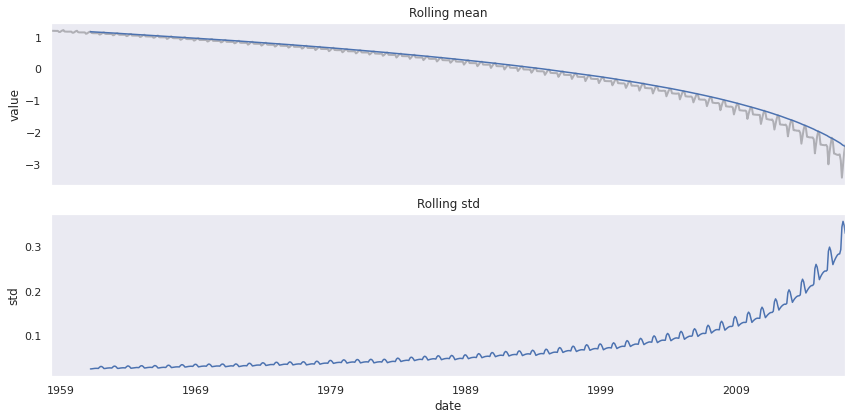

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

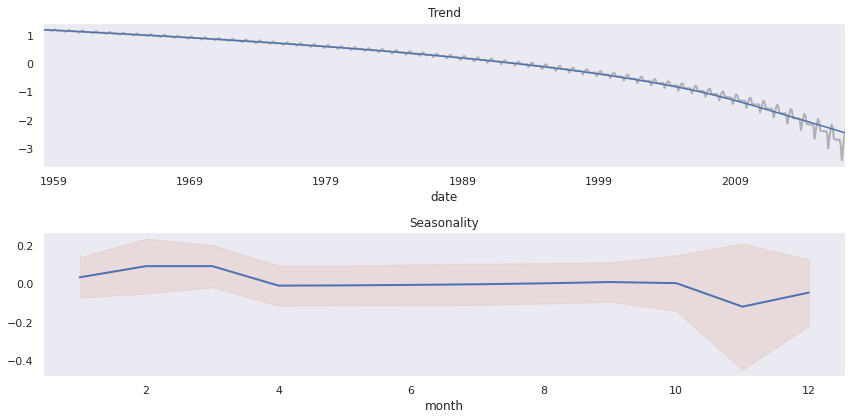

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


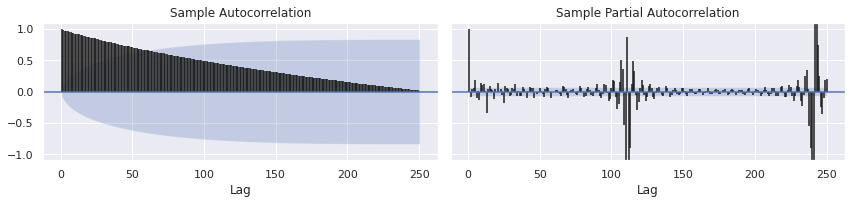

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


{'ADF': (1.5951019960084847, 1.0), 'KPSS': (3.173740679908051, 0.01)}

In [48]:
diagnostics(log_dataset[target_column], window=36)

The transformation did not make any significant changes, but usually taking logarithms makes the estimation of model parameters more stable.

Transform the training sample in advance

In [49]:
train2 = transformer.fit_transform(train.values)

train2 = pd.DataFrame(train2, index=train.index, columns=train.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:106: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  " 'check_inverse=False'.", UserWarning)


### B. Holt-Winters model  of trend and seasonality 

Generalized exponential smoothing with local linear trends and seasonality

* **+** simple model based on simple ideas

* **-** usually the selected trend is a little " late"

* **-** deterministic period of seasonality set manually

The forecast of the value $y_{t+h}$ for $h$ steps forward from the moment $t$ has the form

$$
    \hat{y}_{t+h\mid t}
        = l_t + h b_t + s_{t - m + h^+_m}
        \,, \quad
    h^+_\pi
        = 1 + \bigl((h - 1) \!\!\! \mod m\bigr)
\,, $$

where
* $m$ -- the period of seasonal cycle, $h^+_m$ the index of the seasonal effect
* Local *level* of the series $l_t = \alpha (y_t - s_{t-m}) + (1 - \alpha) (l_{t-1} + b_{t-1})$
* Local *trend slope* $b_t = \beta (l_t - l_{t-1}) + (1 - \beta) b_{t-1}$
* *Periodic* effects $ s_t = \gamma (y_t - (l_{t-1} + b_{t-1})) + (1 - \gamma) s_{t-m}$

Parameters are evaluated by solving the problem of minimizing *standard deviation*
$\hat{y}_{t+1\mid t}$ from $y_{t+1}$:

* $\alpha$, $\beta$ and $\gamma$
* the initial effects of seasonality $s_1,\,\ldots,\,s_m$
* the initial level and the slope coefficient $l_1$ и $b_1$

If there is no seasonality ($s_t=0$) and slope ($b_t = 0$) then

* for $\alpha \approx 1$ the forecast $\hat{y}_{t+h\mid t}$ with the value $y_{t+h}$ is $y_t$

* for $\alpha\approx 0$ the forecast corresponds to the historical average

In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [51]:
exp_smooth = ExponentialSmoothing(train2,
                                  trend="add",         # additive trend
                                  seasonal="add",      # additive seasonality
                                  seasonal_periods=12)

exp_smooth_fitted = exp_smooth.fit(remove_bias=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [52]:
print("Level {smoothing_level:.3f} "\
      "slope {smoothing_slope:.3f} "\
      "seasonality {smoothing_seasonal:.3f}".format(**exp_smooth_fitted.params))

Level 0.158 slope 0.158 seasonality 0.842


Let's look at its residuals in the training set

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

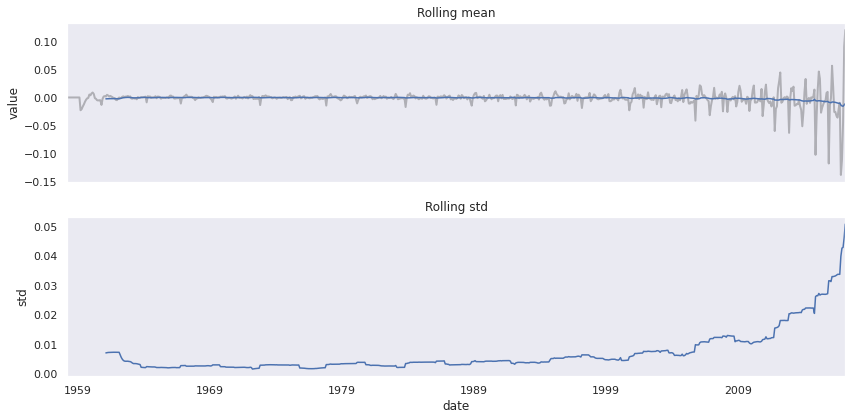

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

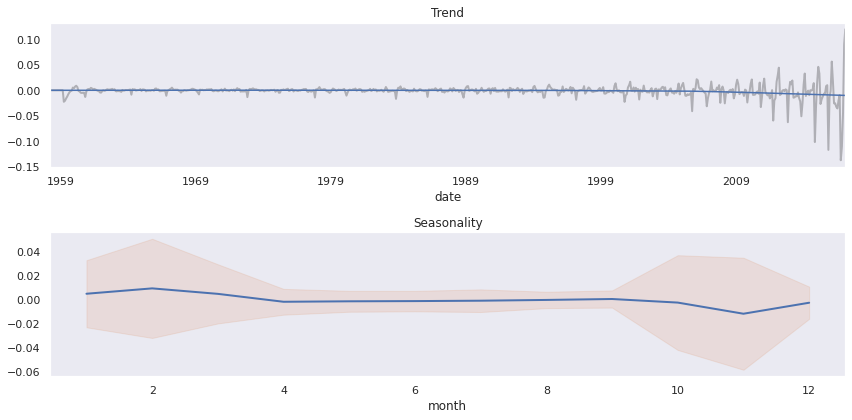

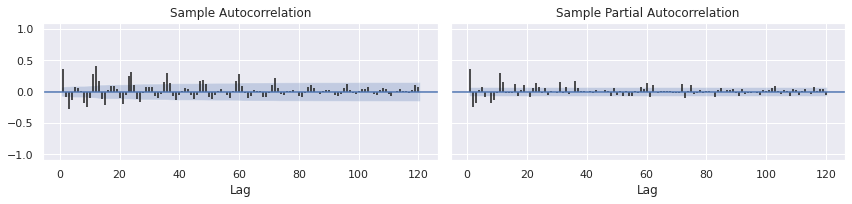

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


{'ADF': (-4.239391024586114, 0.0039008470420194025),
 'KPSS': (0.9809353661315496, 0.01)}

In [53]:
diagnostics(exp_smooth_fitted.resid, window=36, lags=120)

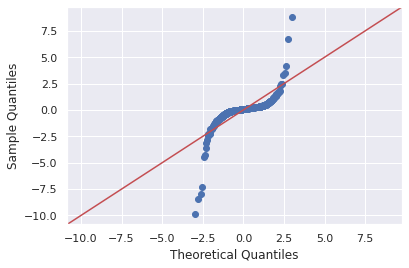

In [54]:
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

qqplot(exp_smooth_fitted.resid, fit=True, line='45');

Do not forget that we have applied transformations to the series

In [0]:
series_fitted = exp_smooth_fitted.fittedvalues.to_frame()

series_fitted = transformer.inverse_transform(series_fitted)

fitted_holt_winters = pd.Series(series_fitted.ravel(),
                                name=target_column,
                                index=train.index)

Let's look at the approximation

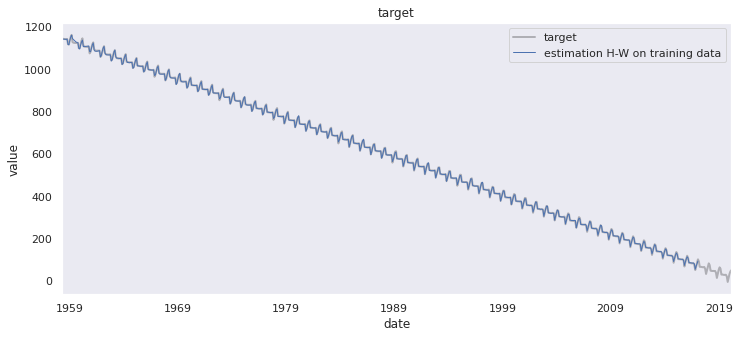

In [56]:
# create and customize the figures: left and right
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# draw the dynamics of the entire series
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=.25, zorder=-10)

fitted_holt_winters.plot(ax=ax, color="C0", lw=1, alpha=1.0,
                         label="estimation H-W on training data")

ax.grid(which="major", axis="both")
ax.legend() ;



Let's look at the residuals in the training sample

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

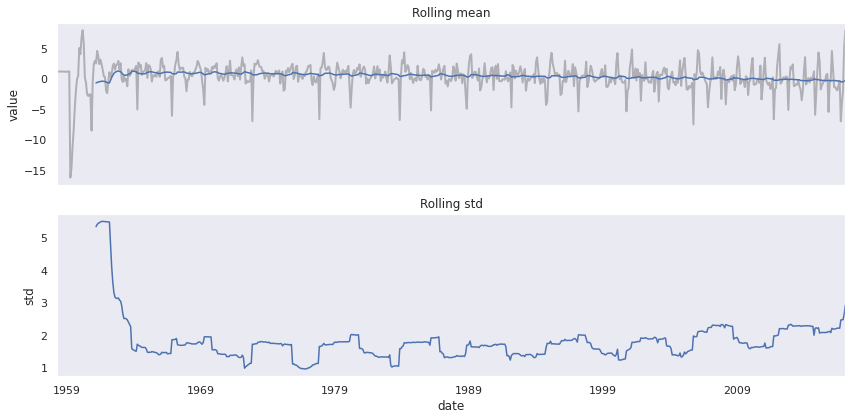

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

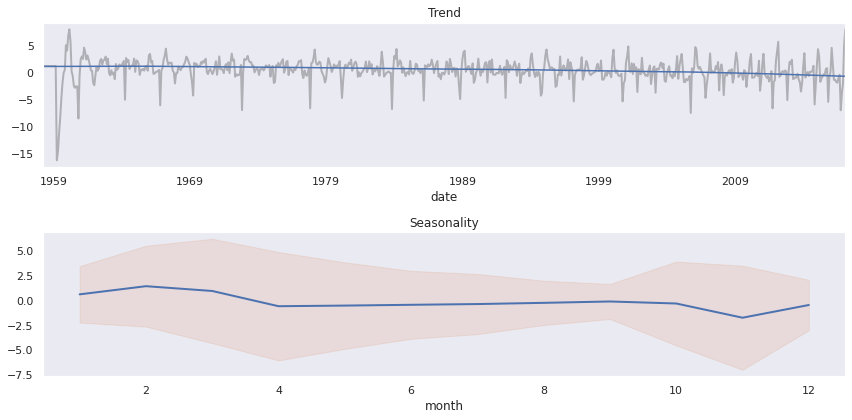

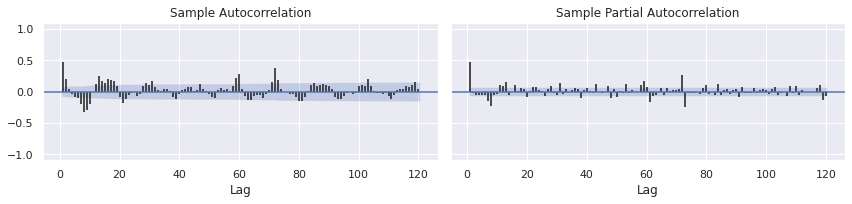

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


{'ADF': (-10.436207050940775, 2.864786578868945e-16),
 'KPSS': (0.9493597585175415, 0.01)}

In [57]:
residuals = train[target_column] - fitted_holt_winters

diagnostics(residuals, window=36, lags=120)

Construct a quantile-quantile Q-Q plot for residuals at the original scale

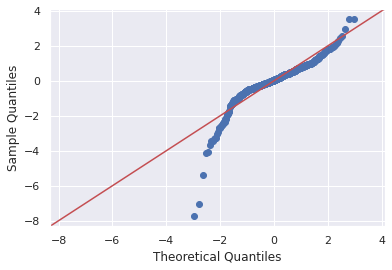

In [58]:
qqplot(residuals, fit=True, line='45');

Judging by sample autocorrelations residuals series are very similar to stationary ones

* no autocorrelations left
* there is no deterministic or stochastic trend

**CONCLUSION** The exponential smoothing model can be **useful** for predicting this process.

### B. Validation of the time series model 

#### Forecasting

**Aim** -- build a trajectory of future values forecasts on the $h$ horizon based on available information at the time of $t$ *inclusive*.

* If **exogenous** variables are involved in the time series model, it is necessary to **know future trajectory** of exogenous variables $x_{t+h},\,x_{t+h-1},\,\ldots$
  - forecasts $x_t$ from other models (which should not use $y_t$)
  
#### Dynamic or out-of-sample

Forecasts $\hat{y}_{s\mid t}$ for $s = t+1,\,\ldots,\, t+h$ calculated by

* trajectories of **exogenous** variables up to moment $s$ *including* the moment $s$ ($x_s,\,x_{s-1},\,\ldots$)

* the history of predictions $\hat{y}_{j\mid t}$ for $j = s-1,\,\ldots,\,t,\,t-1,\,\ldots$, with $\hat{y}_{j\mid t} = y_j$ if $j\leq t$ -- the actual historical value is used.

\begin{aligned}
  & t+1\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \color{blue}{\hat{y}_{t+1\mid t}}
  , \color{gray}{\hat{y}_{t+2\mid t}}
  , \ldots
  , \color{gray}{\hat{y}_{t+h-1\mid t}}
  , \color{gray}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+h\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
        \,\, \hat{y}_{t+1\mid t}
        , \hat{y}_{t+2\mid t}
        , \ldots
        , \hat{y}_{t+h-1\mid t}
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \hat{y}_{t+1\mid t}
  , \hat{y}_{t+2\mid t}
  , \ldots
  , \hat{y}_{t+h-1\mid t}
  , \color{blue}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

#### Static or in-sample

Calculate sequential one-step dynamic forecasts
$\tilde{y}_s = \hat{y}_{s\mid s-1}$ for $s=t+1,\,\ldots,\,t+h$

- must be available **trajectory values** of endogenous variables $y_t$ (*actual*);
Useful
- to validate a pre-trained model on a known dataset

\begin{aligned}
  & t+1\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
      }}^{\color{blue}{\hat{y}_{t+1\mid t}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , \color{red}{y_{t+1}}
  , \color{gray}{y_{t+2}}
  , \ldots
  , \color{gray}{y_{t+h-1}}
  , \color{gray}{y_{t+h}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+2\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        , y_{t+1}
      }}^{\color{blue}{\hat{y}_{t+2\mid t+1}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , y_{t+1}
  , \color{red}{y_{t+2}}
  , \ldots
  , \color{gray}{y_{t+h-1}}
  , \color{gray}{y_{t+h}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+h\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        , y_{t+1}
        , y_{t+2}
        , \ldots
        , y_{t+h-1}
      }}^{\color{blue}{\hat{y}_{t+h\mid t+h-1}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , y_{t+1}
  , y_{t+2}
  , \ldots
  , y_{t+h-1}
  , \color{red}{y_{t+h}}
  , \ldots
\end{aligned}

We will validate the forecast using these metrics:

$$
    MSE(y, \hat{y})
        = \tfrac1{m} \sum_{i=1}^m (y_i - \hat{y}_i)^2
\,. $$

$$
    RMSE(y, \hat{y}) = \sqrt{MSE(y, \hat{y})}
\,. $$

$$
    MAE(y, \hat{y})
        = \tfrac1{m} \sum_{i=1}^m \bigl\lvert y_i - \hat{y}_i \bigr\rvert
\,. $$

$$
    \text{Median-AE}(y, \hat{y})
        = \text{median}\bigl\{
            \lvert y_1 - \hat{y}_1\rvert
            ,\, \ldots ,\,
            \lvert y_m - \hat{y}_m\rvert \bigr\}
\,. $$

$$ 
    MAPE(y, \hat{y})
        = \frac1{m} \sum_{i=1}^m
            \frac{\lvert y_i - \hat{y}_i \rvert}{\lvert y_i \rvert}
\,.$$

$$
    R^2(y, \hat{y})
        = 1- \frac{\sum_{i=1}^m (y_i - \hat{y}_i)^2}{\sum_{i=1}^m (y_i - \bar{y})^2}
\,. $$

$$
    \text{Explained Variance}(y, \hat{y})
        = 1 - \frac{\mathop{var}(y - \hat{y})}{\mathop{var}(y)}
\,. $$

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

In [0]:
def root_mean_squared_error(*args, **kwargs):
    return np.sqrt(mean_squared_error(*args, **kwargs))

def mean_absolute_percent_error(y_true, y_pred):
    pct_error = abs(y_true - y_pred) / abs(y_true)
    return pct_error.mean(axis=0) * 100

All metrics in the list below

In [0]:
scorers = [
    #("expl-var", explained_variance_score),
    ("mse", mean_squared_error),
    ("rmse", root_mean_squared_error),
    ("mae", mean_absolute_error),
    ("median-ae", mean_absolute_error),
    ("r2", r2_score),
    ("mape", mean_absolute_percent_error)
]

Let's look at the **dynamic** forecast

In [0]:
exp_forecast = exp_smooth_fitted.forecast(steps=test_size).to_frame()

exp_forecast = pd.DataFrame(transformer.inverse_transform(exp_forecast),
                            columns=exp_forecast.columns,
                            index=exp_forecast.index)

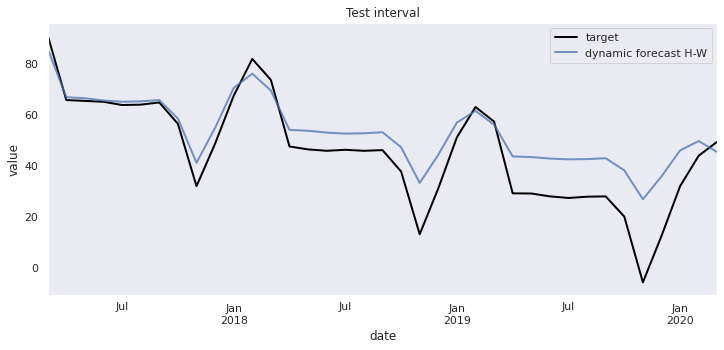

In [63]:
# create and customize the figures
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title="Test interval")

# plot the dynamics
holdout[target_column].plot(ax=ax, color="black", lw=2, alpha=1., zorder=-10)

exp_forecast[0].plot(ax=ax, color="C0", lw=2, alpha=0.75, label="dynamic forecast H-W")

ax.grid(which="major", axis="both")
ax.legend()

Calculate metrics

In [0]:
holdout_exp_smooth_score_values = pd.Series({
    name: metric(holdout[target_column], exp_forecast.iloc[:len(holdout), 0])
    for name, metric in scorers
})

In [65]:
holdout_exp_smooth_score_values

mse          126.986841
rmse          11.268844
mae            8.668637
median-ae      8.668637
r2             0.694897
mape          44.058729
dtype: float64

In [66]:
holdout[target_column].std()

20.6826171875

Compare with the simplest baseline -- **forecast by the last known value**

In [0]:
last_known_forecast = full_dataset.shift(1).loc[holdout_slice]

holdout_last_known_score_values = pd.Series({
    name: metric(holdout[target_column], last_known_forecast[target_column])
    for name, metric in scorers
})

In [68]:
holdout_last_known_score_values

mse          188.948395
rmse          13.745851
mae            9.897223
median-ae      9.897223
r2             0.546026
mape          39.847317
dtype: float64

### Validation of the time series model

Sliding validation forward in time:

1 . consecutive **leave-one-out**:

  - fit the model, predict one future observation, shift to one observation
  
2 . consecutive $k$-**fold**:

  - split the sample into $k$ consecutive blocks **without** mixing

  - fit the model, predict the entire next block, moving one block forward  

Length of the training sample during validation

- a fixed number of observations $w$ in the training sample $(x_s, y_s)_{s=t+1-w}^t$ -- *(rolling window)*

- the training sample contains the entire history of observations $(x_s, y_s)_{s \leq t}$ -- *(rolling prediction origin)*

#### One-step with a fixed-length training sample
<a href="https://drive.google.com/uc?id=1EC1mgQLBXuqTf3zLasRz2VHd4vOT99YL
" target="_blank"><img src="https://drive.google.com/uc?id=1EC1mgQLBXuqTf3zLasRz2VHd4vOT99YL" 
alt="https://blog.cadre.com/how-cadre-uses-machine-learning-to-target-real-estate-markets-3c03ca1dac26" width="600" border="0" /></a>

#### $k$-fold with a growing training sample
`Scikit-learn` has a procedure for $k$-fold fold validation of a time series with a **growing training sample**
<a href="https://drive.google.com/uc?id=1Q45UVpyWir1BCTTlxfYXX37J2VseCPfT
" target="_blank"><img src="https://drive.google.com/uc?id=1Q45UVpyWir1BCTTlxfYXX37J2VseCPfT" 
alt="https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection" width="600" border="0" /></a>

Resources: https://habr.com/ru/company/ods/blog/327242/ 


In [0]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=20, max_train_size=None)

Let's use convenient functions from `scikit` to index `pandas`  matrices and copy models

In [0]:
from sklearn.utils import safe_indexing

from sklearn.base import clone

Validate the model

In [71]:
raw_forecast = np.full_like(train, np.nan)
for train_ix, test_ix in tqdm(tscv.split(train2)):
    # split into train and test
    cv_train = safe_indexing(train, train_ix)

    # 1. "direct transformation" of series
    cv_transformer = clone(transformer).fit(cv_train)
    cv_train = pd.DataFrame(cv_transformer.transform(cv_train),
                            index=cv_train.index, columns=cv_train.columns)

    # 2. fit the model
    cv_model = ExponentialSmoothing(cv_train[target_column], trend="add",
                                    seasonal="add", seasonal_periods=12)
    cv_model = cv_model.fit()

    # 3. building a forecast
    cv_test = safe_indexing(train, test_ix)
    cv_forecast = cv_model.forecast(len(cv_test)).to_frame()

    # 4. "inverse transformation" of series
    raw_forecast[test_ix] = cv_transformer.inverse_transform(cv_forecast)

tscv_exp_smooth_forecast = pd.DataFrame(raw_forecast, index=train.index, columns=train.columns)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:106: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  " 'check_inverse=False'.", UserWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
1it [00:00,  7.92it/s]/usr/

Put the forecasts in a series and plot them

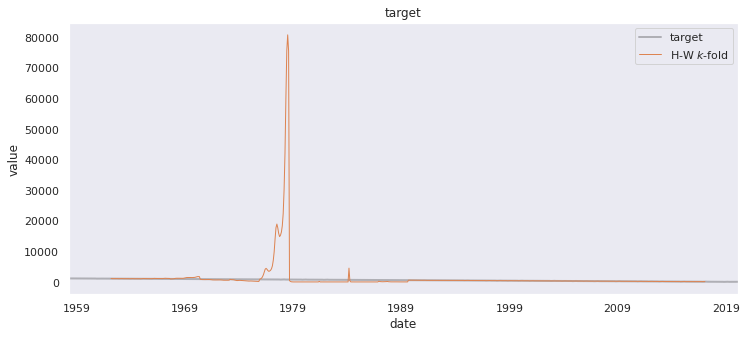

In [72]:
# create and customize the figures
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# draw the dynamics of the entire series and forecasts
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_exp_smooth_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                             label="H-W $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;

Calculate metrics on " test intervals"

In [0]:
has_forecast = tscv_exp_smooth_forecast.isnull().any(axis=1)

In [0]:
predictions = tscv_exp_smooth_forecast.loc[~has_forecast].replace([np.inf, -np.inf], np.nan).fillna(0)

exp_smooth_score_values = pd.DataFrame.from_dict({
    name: metric(train.loc[~has_forecast], predictions)
    for name, metric in scorers
})

In [75]:
exp_smooth_score_values

,mse,rmse,mae,median-ae,r2,mape
target,40436124.0,6358.94043,1062.611206,1062.611206,-478.708464,137.867798


Compare with the baseline on the training folds

In [0]:
last_known_forecast = train.shift(1)

has_forecast = last_known_forecast.isnull().any(axis=1)

last_known_score_values = pd.DataFrame.from_dict({
    name: metric(train.loc[~has_forecast],
                  last_known_forecast.loc[~has_forecast])
    for name, metric in scorers
})

In [77]:
last_known_score_values

,mse,rmse,mae,median-ae,r2,mape
target,240.834915,15.518857,10.12446,10.12446,0.997501,2.700015


## 4. Building an autoregression model and moving average model

Autoregressive Integrated Moving Average (ARIMA) and Seasonal Autoregressive Integrated Moving Average (SARIMA), 
the second model requires selecting hyperparameters for both trend and seasonal elements of the series.


Read here: [seasonality in the autoregressive models](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)
    
* $\phi(\cdot)$ и $\theta(\cdot)$ -- "the lag polynomials" do not have common roots

* $\phi(\cdot)$ does not have single roots

* $\varepsilon_t$ -- white noise, i.e. has zero mean, constant variance, and zero autocorrelations.

The $ARIMAX(p, d, q)$ process with exogenous variables has the form

\begin{align}
    y_t &= \overbrace{\mu + x_t \beta}^{\tau_t}+ \delta_t
        \,, \\
    (1 - L)^d \, \delta_t &= u_t
        \,, \\
    \underbrace{\Bigl(1 - \sum_{k=1}^p \phi_k L^k \Bigr)}_{\phi(L)}
        \, u_t &= \mu + \underbrace{\Bigl( 1 + \sum_{k=1}^q \theta_k L^k \Bigr)}_{\theta(L)}
        \, \varepsilon_t
        \,,
\end{align}

where $L$ -- shift operator back one step in the past, i.e. $L\, y_t = y_{t-1}$

The $ARIMAX(p, d, q)$ process with exogenous variables has the form

    p: the number of autoregressive lags included in the model
    d: the degree of differencing 
    q: the number of moving average lags

\begin{align}
    y_t &= \overbrace{\mu + x_t \beta}^{\tau_t}+ \delta_t
        \,, \\
    (1 - L)^d \, \delta_t &= u_t
        \,, \\
    \underbrace{\Bigl(1 - \sum_{k=1}^p \phi_k L^k \Bigr)}_{\phi(L)}
        \, u_t &= \mu + \underbrace{\Bigl( 1 + \sum_{k=1}^q \theta_k L^k \Bigr)}_{\theta(L)}
        \, \varepsilon_t
        \,,
\end{align}

where $L$ -- shift operator back one step in the past, i.e. $L\, y_t = y_{t-1}$

* $\phi(\cdot)$ and $\theta(\cdot)$ -- "the lag polynomials" do not have common roots

* $\phi(\cdot)$ does not have single roots

* $\varepsilon_t$ -- white noise, i.e. has zero mean, constant variance, and zero autocorrelations.

#### ARIMA model evaluation strategy (Box-Jenkins)

1. Check the assumptions about stationarity, and find the transformations that bring the series to stationary view.

2. Using autocorrelation diagnostics, determine the order of lags in the AR (`pacf`)and MA (`acf`) parts.  Estimate the seasonality.

3. Among reasonable combinations of parameters, choose the model with the lowest criterion **BIC** or **AIC**.

In [0]:
from statsmodels.tsa.arima_model import ARIMA

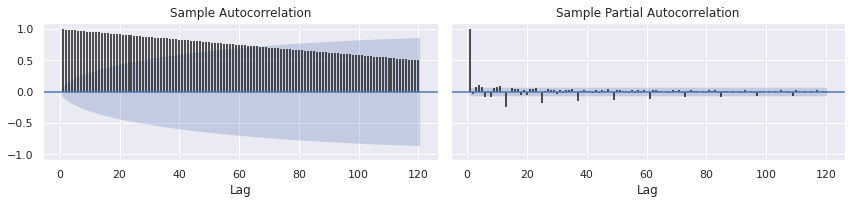

In [79]:
correlation_diagnostics(train, lags=120);

* autocorrelation of small lags is close to $1.0$ and decreases quite slowly
* there are suspicious fluctuations

Perhaps, there is a single root $y_t = y_{t-1} + \ldots$.

Train the model ARIMA $(0, 1, 0)$

In [0]:
model_010 = ARIMA(train2, order=(0, 1, 0))

model_010_fitted = model_010.fit(disp=0)

Let's look at its residuals in the training sample (and in differences)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

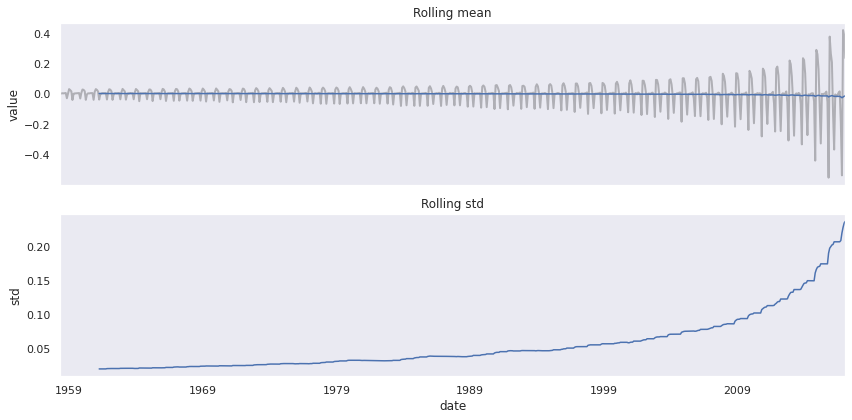

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

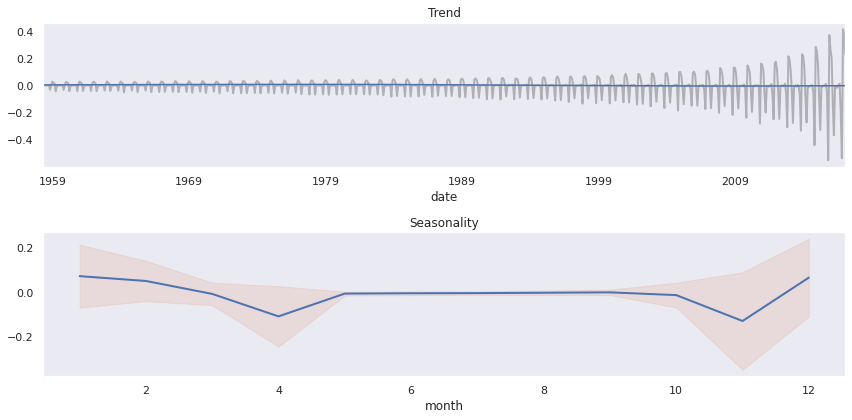

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


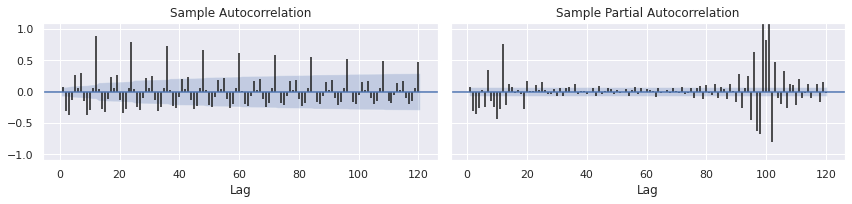

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


{'ADF': (5.88181742692228, 1.0),
 'KPSS': (0.5154482993135897, 0.03818731997441673)}

In [81]:
diagnostics(model_010_fitted.resid, window=36, lags=120)

* Slow decrease of periodic ($12$) peaks indicates seasonal dependence of the form $y_t = y_{t-12} + \ldots$

The data seems to correlate with each other monthly, but also their level depends on the value of $12$ months ago.

The SARIMA$(p, d, q)\times (P, D, Q)_{s}$ process has the form

\begin{align}
    (1 - L)^d \, (1 - L^s)^D \, y_t &= u_t
        \,, \\
    \Bigl(1 - \sum_{j=1}^p \phi_k L^j\Bigr)
        \, \Bigl(1 - \sum_{j=1}^P \tilde{\phi}_k L^{s j}\Bigr)
        \, u_t &= \mu \, +
        \, \Bigl(1 + \sum_{j=1}^q \theta_k L^j\Bigr)
        \, \Bigl(1 + \sum_{j=1}^Q \tilde{\theta}_k L^{s j}\Bigr)
        \, \varepsilon_t
        \,.
\end{align}

Let's look at its residuals in the training sample for different model orders

In [0]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

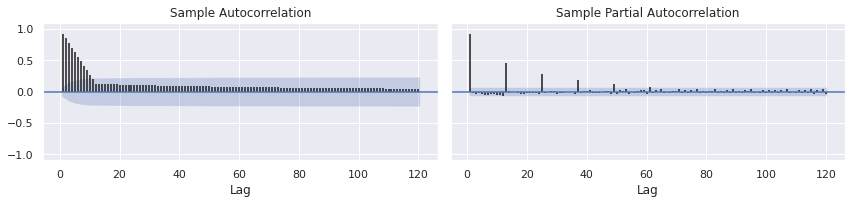

In [83]:
model_sarima_000_010_12 = SARIMAX(train2, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12),
                                  enforce_stationarity=False, enforce_invertibility=False)

model_sarima_000_010_12_fitted = model_sarima_000_010_12.fit(disp=0)

correlation_diagnostics(model_sarima_000_010_12_fitted.resid, lags=120) ;

* While taking the residuals $y_t - y_{t-12}$, it seems that there are traces of the usual unit root

Let's observe the model
$$ 
    (1 - L^{12})(1 - L) y_t
        = \bigl[y_{t} - y_{t-1} - y_{t-12} + y_{t-13}\bigr]
        = \mu + \varepsilon_t
    \,,$$

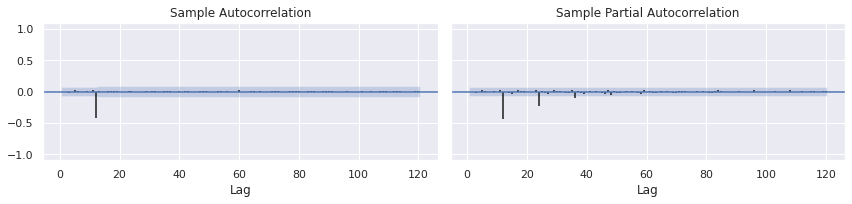

In [84]:
model_sarima_010_010_12 = SARIMAX(train2, 
                                  order=(0, 1, 0), 
                                  seasonal_order=(0, 1, 0, 12),
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

model_sarima_010_010_12_fitted = model_sarima_010_010_12.fit(disp=0)

correlation_diagnostics(model_sarima_010_010_12_fitted.resid, lags=120) ;

* apparently there are non-zero effects from the moving average

Add the moving average to the seasonal and regular parts.

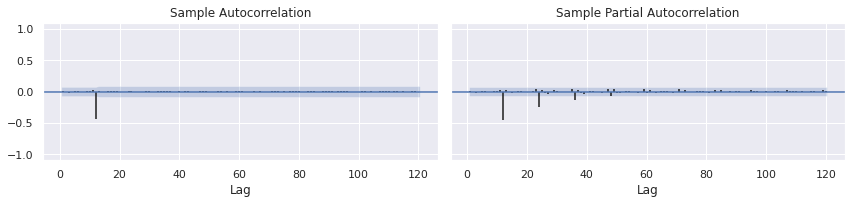

In [85]:
model_sarima_011_011_12 = SARIMAX(train2, 
                                  order=(0, 1, 1), 
                                  seasonal_order=(0, 1, 1, 12),
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

model_sarima_011_011_12_fitted = model_sarima_011_011_12.fit(disp=0)

correlation_diagnostics(model_sarima_011_011_12_fitted.resid, lags=120) ;

Let's try to weaken the unit roots

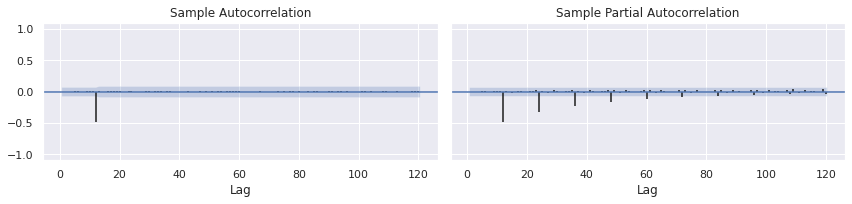

In [86]:
model_sarima_101_101_12 = SARIMAX(train2, 
                                  order=(1, 0, 1), 
                                  seasonal_order=(1, 0, 1, 12),
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

model_sarima_101_101_12_fitted = model_sarima_101_101_12.fit(disp=0)

correlation_diagnostics(model_sarima_101_101_12_fitted.resid, lags=120) ;

Let's return unit roots

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be

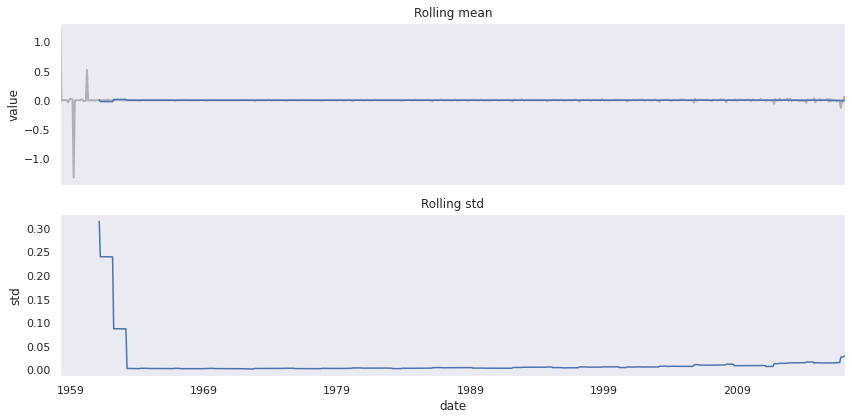

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

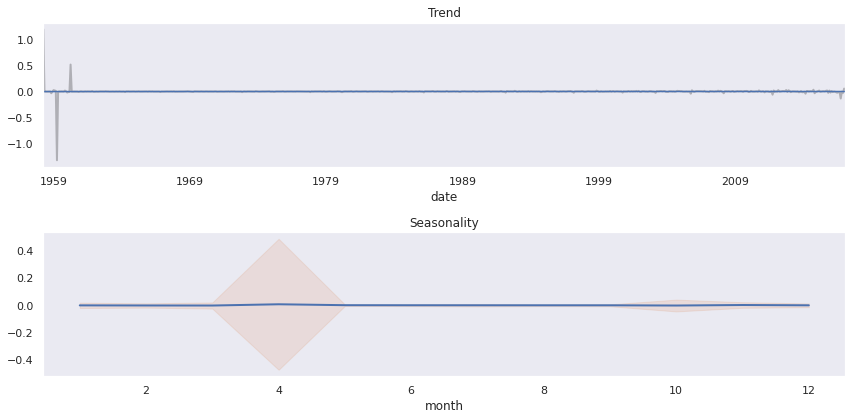

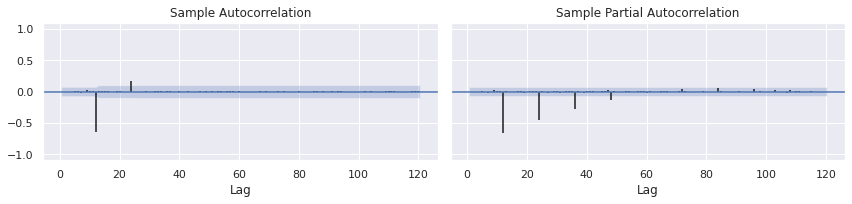

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [87]:
model_sarima_111_111_12 = SARIMAX(train2, 
                                  order=(1, 1, 1), 
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

model_sarima_111_111_12_fitted = model_sarima_111_111_12.fit(disp=0)

diagnostics(model_sarima_111_111_12_fitted.resid, window=36, lags=120) ;

Judging by sample autocorrelations a residuals series are very similar to stationary ones
* there are no autocorrelations left
* there is no deterministic or stochastic trend

**CONCLUSION** The SARIMA$(1,1,1)\times(1,1,1)_{12}$ model can be **useful** for this process forecasting.

Try a more complex model...

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


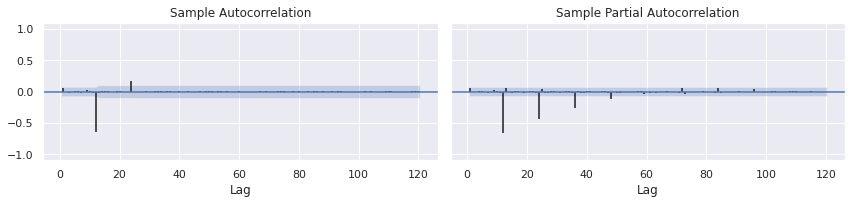

In [88]:
model_sarima_211_111_12 = SARIMAX(train2, 
                                  order=(2, 1, 1), 
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

model_sarima_211_111_12_fitted = model_sarima_211_111_12.fit(disp=0)

correlation_diagnostics(model_sarima_211_111_12_fitted.resid, lags=120) ;

Select the model with the lowest **BIC** value (Bayesian information criterion)

Read here: [information criterion](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B9_%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9)

In [89]:
models = [
  model_010_fitted,
  model_sarima_000_010_12_fitted,
  model_sarima_010_010_12_fitted,
  model_sarima_011_011_12_fitted,
  model_sarima_101_101_12_fitted,
  model_sarima_111_111_12_fitted,
  model_sarima_211_111_12_fitted,
]

[getattr(mdl, "bic") for mdl in models]

[-1574.7439806332532,
 -1358.3370058758583,
 -3990.299258063914,
 -4039.494197086952,
 -4429.137787862528,
 -4406.893369269542,
 -4365.051466125965]

The quantile-quantile Q-Q graph shows the residuals have an approximately normal distribution.

* the first 24 observations were dropped due to the "edge" effects of the sample start

In [0]:
sarima_fitted = models[5]

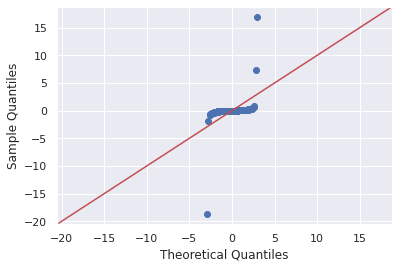

In [91]:
qqplot(sarima_fitted.resid[:], fit=True, line='45');

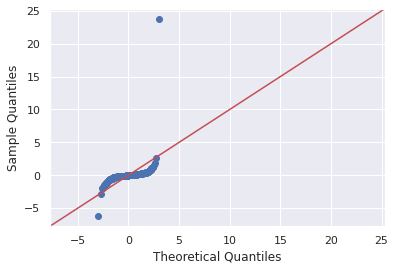

In [92]:
# build the central part
qqplot(sarima_fitted.resid[20:], fit=True, line='45');

The `SARIMAX` returns the fitted values on the training sample in the `fittedvalues`:
* the series corresponds to the prediction in the original data values (**NOT* * in residuals like in `ARIMA`)

In [0]:
if isinstance(sarima_fitted.model, SARIMAX):
    series_fitted = sarima_fitted.fittedvalues.to_frame()

elif isinstance(sarima_fitted.model, ARIMA):
    series_fitted = np.concat([
        train2.iloc[:1],             # add a little history (for integration)
        sarima_fitted.fittedvalues,  # add fitted values
    ], axis=0).cumsum(axis=0)

Inverse transformation

In [0]:
series_fitted = transformer.inverse_transform(series_fitted)

fitted_arima = pd.Series(series_fitted.ravel(),
                         name=target_column,
                         index=train.index)

Look at the fitting plot

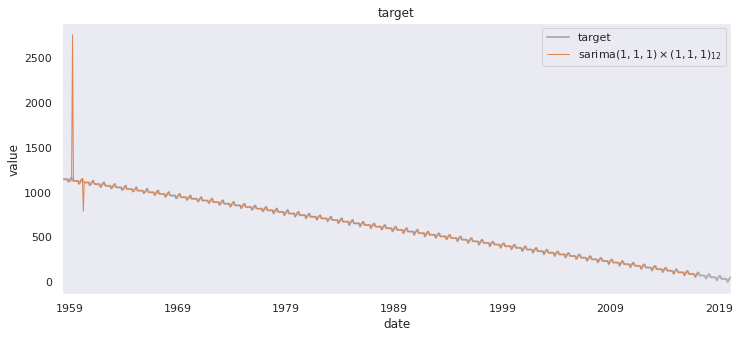

In [95]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# draw the dynamics of the entire series
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

fitted_arima.plot(ax=ax, color="C1", lw=1, alpha=1.0,
                  label="sarima$(1,1,1)\\times(1,1,1)_{12}$")

ax.grid(which="major", axis="both")
ax.legend() ;



Let's look at the **dynamic** forecast

In [0]:
sarima_forecast = sarima_fitted.forecast(steps=test_size).to_frame()

sarima_forecast = pd.DataFrame(transformer.inverse_transform(sarima_forecast),
                            columns=sarima_forecast.columns,
                            index=sarima_forecast.index)

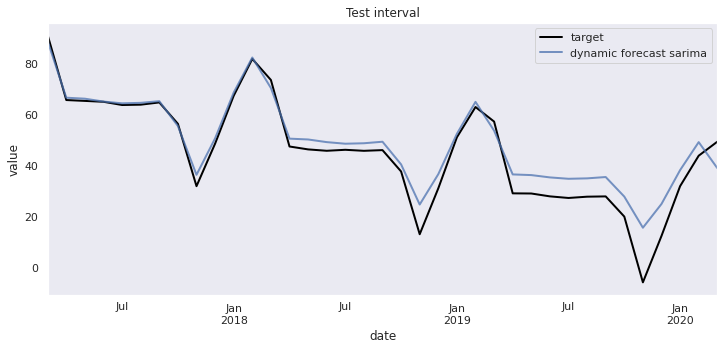

In [97]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title="Test interval")

# draw the dynamics
holdout[target_column].plot(ax=ax, color="black", lw=2, alpha=1., zorder=-10)

sarima_forecast[0].plot(ax=ax, color="C0", lw=2, alpha=0.75, label="dynamic forecast sarima")

ax.grid(which="major", axis="both")
ax.legend() ;

Calculate metrics

In [0]:
holdout_sarima_score_values = pd.Series({
    name: metric(holdout[target_column],
                 sarima_forecast.iloc[:len(holdout), 0])
    for name, metric in scorers
})

In [99]:
holdout_sarima_score_values

mse          40.062681
rmse          6.329509
mae           4.666040
median-ae     4.666040
r2            0.903744
mape         25.071094
dtype: float64

Validate the model

In [100]:
raw_forecast = np.full_like(train, np.nan)
for train_ix, test_ix in tqdm(tscv.split(train)):
    # split into train and test
    cv_train = safe_indexing(train, train_ix)

    # 1. "direct transformation" of series
    cv_transformer = clone(transformer).fit(cv_train)
    cv_train = pd.DataFrame(cv_transformer.transform(cv_train),
                            index=cv_train.index, columns=cv_train.columns)

    # 2. fit the model
    cv_model = SARIMAX(cv_train[target_column],
                       order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

    try:
        cv_model_fitted = cv_model.fit(disp=0)
    except ValueError:
        continue

    # 3. building a forecast
    cv_test = safe_indexing(train, test_ix)
    cv_forecast = cv_model_fitted.forecast(len(cv_test)).to_frame()

    # 4. "inverse transformation" of series
    raw_forecast[test_ix] = cv_transformer.inverse_transform(cv_forecast)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:106: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  " 'check_inverse=False'.", UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:106: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to p

In [0]:
raw_forecast[np.nan_to_num(raw_forecast) <= 0] = np.nan

raw_forecast[~np.isfinite(raw_forecast)] = np.nan

tscv_sarima_forecast = pd.DataFrame(raw_forecast, index=train.index, columns=train.columns)

Put the predictions in a series and plot them

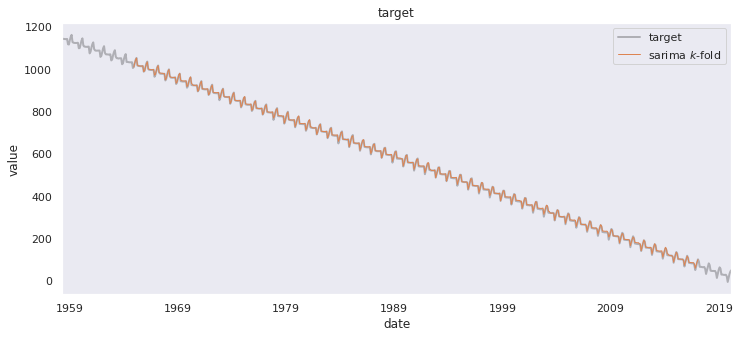

In [102]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# plot the dynamics of the entire series and predictions
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_sarima_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                         label="sarima $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;



Calculate metrics using "test intervals"

In [0]:
has_forecast = tscv_sarima_forecast.isnull().any(axis=1)

sarima_score_values = pd.DataFrame.from_dict({
    name: metric(train.loc[~has_forecast],
                 tscv_sarima_forecast.loc[~has_forecast])
    for name, metric in scorers
})

In [104]:
sarima_score_values

,mse,rmse,mae,median-ae,r2,mape
target,7.769475,2.787378,2.084061,2.084061,0.999898,0.69214


## 5.  Reducing the data dimension

#### A.  Singular spectral decomposition

This method is based on reducing the dimension of the time series special representation

+ **+** works well with multidimensional data
+ **-** requires explicitly specification of the number of hidden factors
+ **-** selected hidden factors must be modeled separately

For this method, we need to "pack" series into a "snake"

* Direct transformation for building a $Y_t$ matrix based on a series $(y_s)_{s=1}^t$:

\begin{equation}
    y_1,\,,\ldots,\,y_{t-1},\,y_t
    \quad \mapsto
    \quad Y_t =
        \begin{pmatrix}
            y_1                 & \color{orange}{y_2} & \color{red}{y_3}  & \cdots & y_p     \\
            \color{orange}{y_2} & \color{red}{y_3}    & \color{blue}{y_4} & \cdots & y_{p+1} \\
            \color{red}{y_3}    & \color{blue}{y_4}   & y_5               & \cdots & y_{p+2} \\
            \vdots              & \vdots              & \vdots            & \ddots & \vdots  \\
            y_{t-p+1}           & y_{t-p+2}           & y_{t-p+3}         & \cdots & y_t     
        \end{pmatrix}
\end{equation}

* Inverse transformation: calculate the average for all anti-diagonals of the matrix $X_t$
* Anti-diagonals in the *lower-right corner*  may be "incomplete"

\begin{equation}
    X_t
    = \begin{pmatrix}
        x^1_p         & \color{orange}{x^{(2)}_p}     & \color{red}{x^{(3)}_p}     & \cdots & x^{(p)}_p     \\
        \color{orange}{x^{(1)}_{p+1}} & \color{red}{x^{(2)}_{p+1}} & \color{blue}{x^{(3)}_{p+1}} & \cdots & x^{(p)}_{p+1} \\
        \color{red}{x^{(1)}_{p+2}} & \color{blue}{x^{(2)}_{p+2}} & x^{(3)}_{p+2} & \cdots & x^{(p)}_{p+2} \\
        \vdots        & \vdots        & \vdots        & \ddots & \vdots        \\
        x^{(1)}_t     & x^{(2)}_t     & x^{(3)}_t     & \cdots & x^{(p)}_t
    \end{pmatrix}
    \quad \mapsto
    \quad \tfrac1{p} \sum_{j=0}^{p-1} \color{red}{x^{(p-j)}_{s+j}}
    \,, s=p,\,\ldots,\,t
\end{equation}

1) Direct transformation creates a $Y_t$ matrix from a series $y_t$

2) Select $m < p$ hidden factors $f_s = (f^{(1)}_s,\,\ldots,\,f^{(m)}_s)$

\begin{equation}
    F_t
    = \begin{pmatrix}
        f^{(1)}_p        & \cdots & f^{(m)}_p      \\
        f^{(1)}_{p+1}    & \cdots & f^{(m)}_{p+1}  \\
        \vdots           & \ddots & \vdots         \\
        f^{(1)}_t        & \cdots & f^{(m)}_t
    \end{pmatrix}
\end{equation}

  * the **PCA** methods searches for $m$-dimensional linear transformation of data into factors:

    - low approximation error: $y_{s+j} \approx \sum_{k=1}^m f^{(k)}_s v_{kj}$
    for all where $s=1\,,\ldots\,,t-p+1$ and $j=0,\,\ldots,\,p-1$

    - the transformation components are linearly independent and pairwise orthogonal
    
Typical situation for methods based on calculating eigenvectors:
* select components ordered by frequency

3)  On the series of the $j$ hidden factor $f^{(j)}_s$ where $s=p,\,p+1,\,\ldots,\,t$ we train the time series model
* we use the Holt-Winters method

4) Predict the hidden factors

In [0]:
n_embedding, n_components = 12, 4

n_samples, n_targets = train.shape

In [0]:
def embed_transform(X, n_embedding):
    # lags from n_lags - 1 to 1
    n_lags = n_embedding - 1
    lagged = [X[k:k - n_lags] for k in range(n_lags)]

    # current value

    lagged.append(X[n_lags:])

    # join and return
    embed = np.stack(lagged, axis=1)
    return embed.reshape(len(X) - n_lags, -1)

In [0]:
def embed_inverse_transform(X, n_targets):
    assert (X.shape[1] % n_targets) == 0

    result = np.zeros((len(X), n_targets), dtype=float)
    for k in range(n_targets):
        # select the k-th feature
        X_k = X[:, k::n_targets]
        n_embedding = X_k.shape[1]

        # calculate the average for all anti-diagonals (even incomplete ones!)
        result[:, k] = np.array([
            np.diag(X_k[j:j + n_embedding, ::-1]).mean()
            for j in range(len(X))
        ])
    return result

In [0]:
data_Y = embed_transform(train2, n_embedding)

In [0]:
from sklearn.decomposition import PCA

ssa = PCA(n_components=n_components)

data_F = pd.DataFrame(ssa.fit_transform(data_Y), index=train.index[n_embedding - 1:])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


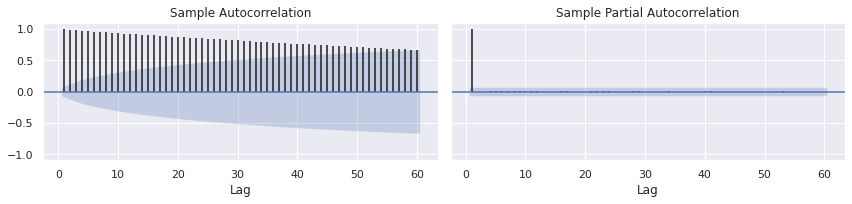

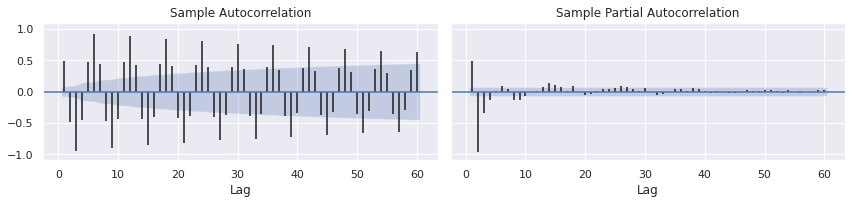

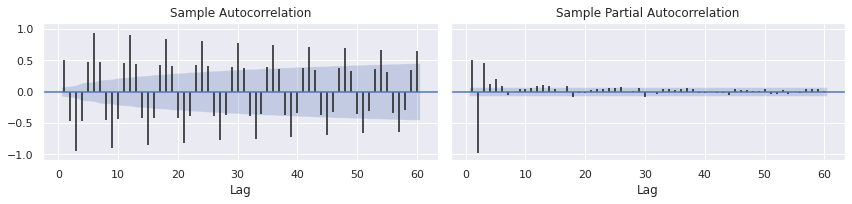

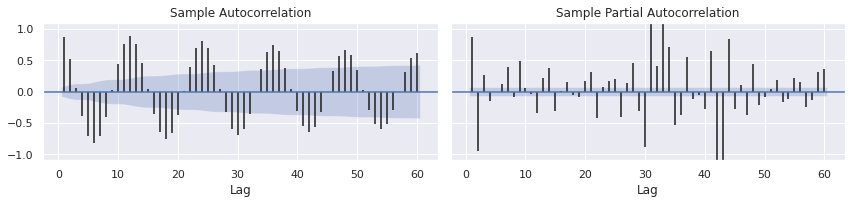

In [110]:
for j in range(ssa.n_components_):
    correlation_diagnostics(data_F[j]) ;

Apply the inverse transformation of factors on the training sample

In [0]:
data_fitted = ssa.inverse_transform(data_F)

ssa_fitted = embed_inverse_transform(data_fitted, n_targets)

ssa_fitted = pd.DataFrame(ssa_fitted, index=data_F.index, columns=train.columns)

Let's look at the residuals

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

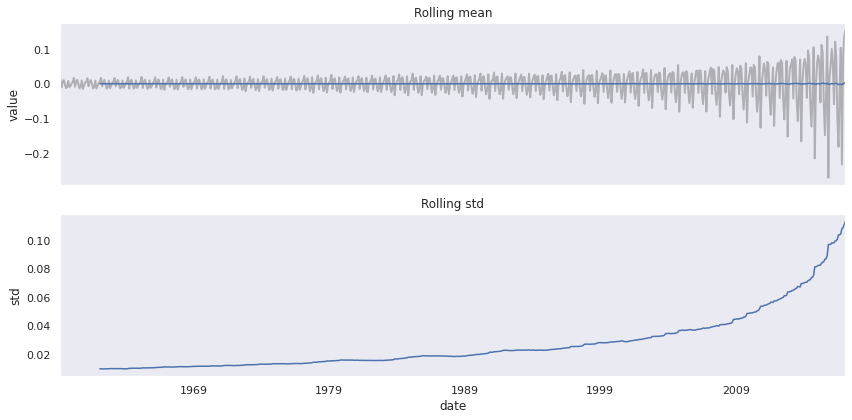

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

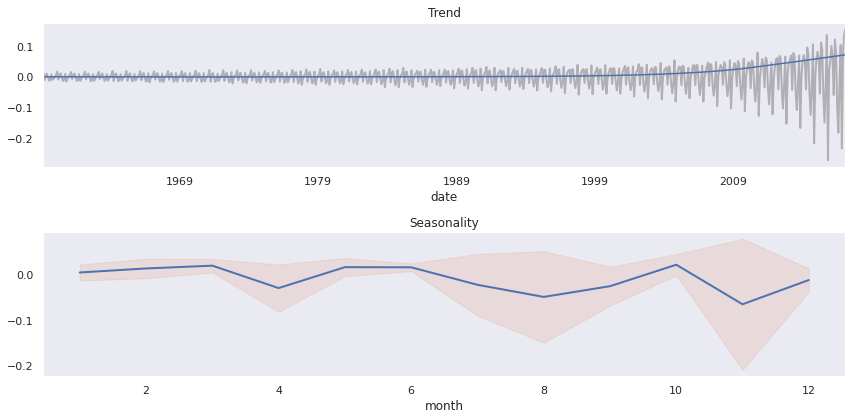

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


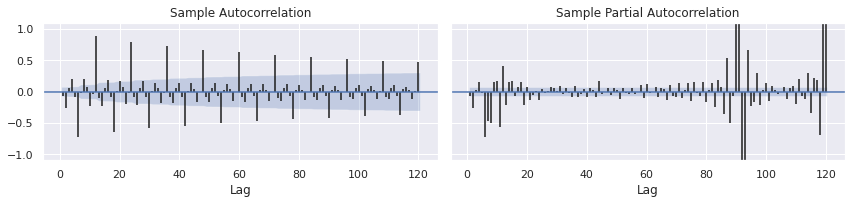

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


{'ADF': (-10.5347006062706, 1.8111851519963377e-16),
 'KPSS': (0.06381032591026685, 0.1)}

In [112]:
ssa_residuals = train2[target_column].iloc[-len(ssa_fitted):] - ssa_fitted[target_column]

diagnostics(ssa_residuals, window=36, lags=120)

In [113]:
models = []
for j in range(ssa.n_components_):
    exp_mod = ExponentialSmoothing(data_F[j], trend="add", seasonal="add",
                                   seasonal_periods=12)
    models.append(exp_mod.fit(remove_bias=True))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [0]:
latent_pred = pd.concat([
    mdl.forecast(test_size) for mdl in models
], axis=1)

Let's look at the forecasts

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

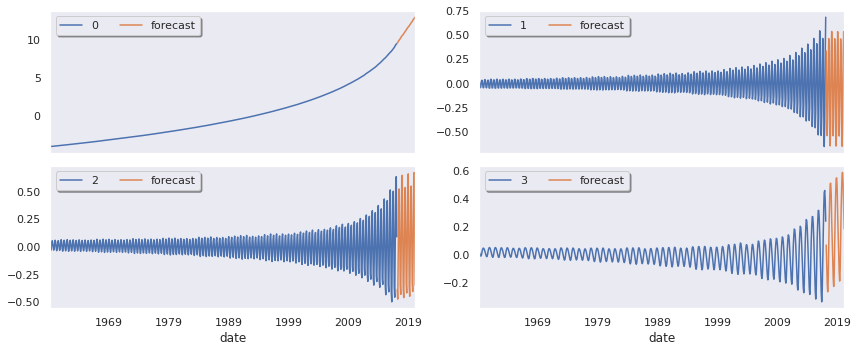

In [115]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
axes = fig.subplots(nrows=2, ncols=2, sharex=True)

for (col, ser), ax in zip(data_F.items(), axes.ravel()):
# draw the dynamics of hidden factors
    ser.plot(ax=ax, color="C0")
    latent_pred[col].plot(ax=ax, color="C1", label="forecast")

    ax.grid(which="major", axis="both")
    ax.legend(loc="upper left", ncol=2, shadow=True)

fig.tight_layout() ;

Plot forecasts for the original series

In [0]:
ssa_forecast = ssa.inverse_transform(latent_pred)

# inverse transformation
ssa_forecast = embed_inverse_transform(ssa_forecast, n_targets)

ssa_forecast = transformer.inverse_transform(ssa_forecast)

ssa_forecast = pd.DataFrame(ssa_forecast, index=latent_pred.index,
                            columns=["prediction "+ col for col in train.columns])

Plot it

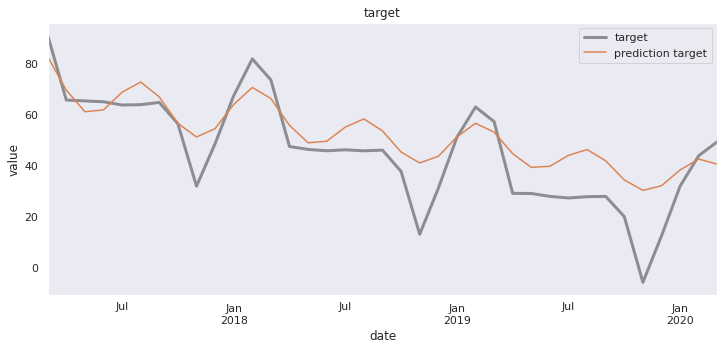

In [117]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# plot the dynamics of the entire series
holdout[target_column].plot(ax=ax, color="black", lw=3, alpha=.4, zorder=-10)

ssa_forecast.plot(ax=ax, color="C1", lw=1.5)

ax.grid(which="major", axis="both")
ax.legend() ;



Calculate metrics

In [0]:
holdout_ssa_score_values = pd.Series({
    name: metric(holdout[target_column],
                 ssa_forecast.iloc[:len(holdout), 0])
    for name, metric in scorers
})

In [119]:
holdout_ssa_score_values

mse          150.764373
rmse          12.278614
mae            9.701174
median-ae      9.701174
r2             0.637768
mape          47.265711
dtype: float64

Validate the model

In [120]:
raw_forecast = np.full_like(train, np.nan)
for train_ix, test_ix in tqdm(tscv.split(train2)):
    # split into train and test
    cv_train = safe_indexing(train, train_ix)
    cv_train_index = cv_train.index

    # 1. "direct transformation" of series
    cv_transformer = clone(transformer)
    cv_train = cv_transformer.fit_transform(cv_train)

    # 2.1 fit the model: selecting factors
    cv_embed_train = embed_transform(cv_train, n_embedding)

    cv_ssa_model = clone(ssa)
    cv_factors = cv_ssa_model.fit_transform(cv_embed_train)

    cv_factors = pd.DataFrame(cv_factors, index=cv_train_index[n_embedding - 1:])

    # 2.2 fit the model: factors
    try:
        cv_models = []
        for j in range(cv_ssa_model.n_components_):
            cv_exp_mod = ExponentialSmoothing(cv_factors[j],
                                              trend="add", seasonal="add",
                                              seasonal_periods=12)

            cv_models.append(cv_exp_mod.fit(remove_bias=True))
    except ValueError:
        continue

    # 3.1 building a forecast: factors
    cv_test = safe_indexing(train, test_ix)

    cv_factors_pred = pd.concat([
        mdl.forecast(len(cv_test)) for mdl in cv_models
    ], axis=1)

    # 3.2 building a forecast: reverse embedding and anti-diagonal averaging
    cv_ssa_forecast = cv_ssa_model.inverse_transform(cv_factors_pred)

    cv_ssa_forecast = embed_inverse_transform(cv_ssa_forecast, n_targets)

    # 4. "inverse transformation" of series
    raw_forecast[test_ix] = cv_transformer.inverse_transform(cv_ssa_forecast)

tscv_ssa_forecast = pd.DataFrame(raw_forecast, index=train.index, columns=train.columns)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:106: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  " 'check_inverse=False'.", UserWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
1it [00:00,  3.80it/s]/usr/

Collect all predictions to a single series and plot them

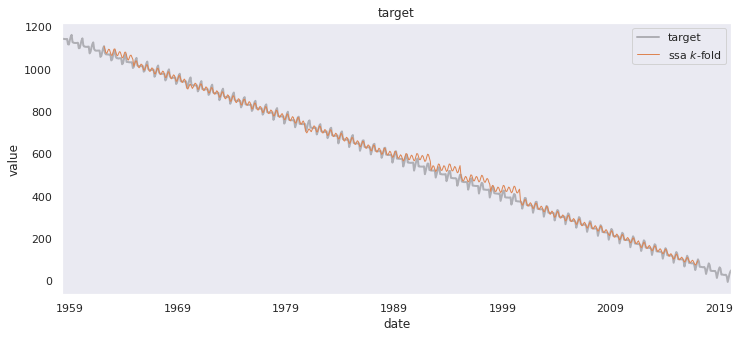

In [121]:
# create and customize the figure
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Date", ylabel="value", title=target_column)

# plot the dynamics of the entire series and predictions
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=0.25, zorder=-10)

tscv_ssa_forecast[target_column].plot(ax=ax, color="C1", lw=1, alpha=1.0,
                                      label="ssa $k$-fold")

ax.grid(which="major", axis="both")
ax.legend() ;



Calculate metrics on "test intervals"

In [0]:
has_forecast = tscv_ssa_forecast.isnull().any(axis=1)

ssa_score_values = pd.DataFrame.from_dict({
    name: metric(train.loc[~has_forecast],
                 tscv_ssa_forecast.loc[~has_forecast])
    for name, metric in scorers
})

In [123]:
ssa_score_values

,mse,rmse,mae,median-ae,r2,mape
target,328.779602,18.13228,12.834656,12.834656,0.9961,3.124492


## 6. Comparison of predictive models

Summary table of metrics on holdout

In [0]:
holdout_score_values = pd.concat({
    "last known": holdout_last_known_score_values,
    "Holt-Winters": holdout_exp_smooth_score_values,
    "SARIMA": holdout_sarima_score_values,
    "SSA": holdout_ssa_score_values
}, axis=1)

In [125]:
holdout_score_values.style.background_gradient(axis=1, cmap=plt.cm.RdYlGn_r)

,last known,Holt-Winters,SARIMA,SSA
mse,188.948,126.987,40.0627,150.764
rmse,13.7459,11.2688,6.32951,12.2786
mae,9.89722,8.66864,4.66604,9.70117
median-ae,9.89722,8.66864,4.66604,9.70117
r2,0.546026,0.694897,0.903744,0.637768
mape,39.8473,44.0587,25.0711,47.2657


Summary table of metrics on cross validation folds

In [0]:
cv_score_values = pd.concat({
    "last known": last_known_score_values,
    "Holt-Winters": exp_smooth_score_values,
    "SARIMA": sarima_score_values,
    "SSA": ssa_score_values
}, axis=1).stack()

In [127]:
cv_score_values.loc[target_column].style.background_gradient(axis=1, cmap=plt.cm.RdYlGn_r)

,last known,Holt-Winters,SARIMA,SSA
mse,240.835,4.04361e+07,7.76947,328.78
rmse,15.5189,6358.94,2.78738,18.1323
mae,10.1245,1062.61,2.08406,12.8347
median-ae,10.1245,1062.61,2.08406,12.8347
r2,0.997501,-478.708,0.999898,0.9961
mape,2.70002,137.868,0.69214,3.12449


## 7. Recurrent Neural Networks

Now, we will see, if we can also use neural networks for forecasting. In the homework, you will look a bit more in-depth on the theory behind RNNs. Here, we will put them into practice.

We start by defining our classes. It will be a simple RNN

In [0]:
# Design structure of deep neural network model
# Ref: https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential
class Net(nn.Module):

    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.num_layers = 2
        # hidden_size – The number of features in the hidden state h
        self.hidden_size = hidden_size
        # input_size: The number of expected features in the input `x`
        # batch_first: the input and output tensors are provided as `(batch, seq, feature)`
        self.SimpleRNN = nn.RNN(input_size=1, hidden_size=self.hidden_size,
                                num_layers=self.num_layers, batch_first=True)
        # In PyTorch, RNN doesn't have ``return_sequences```
        # Ref: https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#RNN
        # layer_input_size = input_size if layer == 0 else hidden_size * num_directions
        # num_layers: Number of recurrent layers. E.g., setting ``num_layers=2`` 
        # would mean stacking two RNNs together to form a `stacked RNN`, 
        # with the second RNN taking in outputs of the first RNN and computing the final results.
        # Note: **output** of shape `(seq_len, batch, num_directions * hidden_size)`
        self.Dense = nn.Linear(self.hidden_size, 1)

    def forward(self, x):
        # Ref: https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
        batch_size = x.size(0)
        x = t.unsqueeze(x, 2)
        hidden = self.init_hidden(batch_size)
        output, hidden = self.SimpleRNN(x, hidden)
        output = self.Dense(output[:, -1, :])  # only take last one of output
        result = output * 100.0
        return result

    def init_hidden(self, batch_size):
        hidden = t.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden

class History():
    """
    The `History` object gets returned by the `fit` method of models.
    """

    def __init__(self, metric_name):
        self.history = {'loss': [], metric_name: []}

    def append_log(self, log_key, log_value):
        self.history[log_key].append(log_value)

# Define metric and learning algorithms.
# As well as train(fit) and predict.
class Sequential():

    def __init__(self, model):
        self.model = model
        self.metric = None
        self.optimizer = None
        self.loss = None

    def t_compile(self, loss, metric, optimizer):
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    def t_fit(self, dataset, epochs, callbacks=[], verbose=0):
        history = History('{0}'.format(self.metric.__name__))
        if(callbacks != []):
            scheduler = LambdaLR(self.optimizer, lr_lambda=callbacks)
        for epoch in range(epochs):
            running_loss = 0.0
            Outputs_epoch = []
            Labels_epoch = []
            for i, data in enumerate(dataset, 0):
                inputs, labels = data
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                Loss = self.loss(outputs, labels)
                Loss.backward()
                self.optimizer.step()
                running_loss += Loss.item()
                Outputs_epoch.append(outputs)
                Labels_epoch.append(labels)
            if(callbacks != []):
                scheduler.step()
            history.append_log('loss', running_loss / i)
            history.append_log(self.metric.__name__,
                               self.metric(t.cat(Labels_epoch).detach().numpy(),
                                           t.cat(Outputs_epoch).detach().numpy()))
        print('Finished Training')
        return history

    def t_predict(self, dataset):
        return self.model(dataset)

We define again a time series to work with

In [0]:
t.manual_seed(1729)
np.random.seed(1729)

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

# Train and validate split
split_time = 1000
time_train = times[:split_time]
x_train = series[:split_time]
time_valid = times[split_time:]
x_valid = series[split_time:]

Let's look at the time series

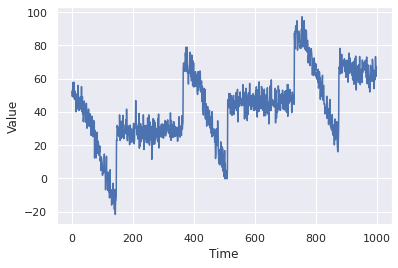

In [130]:
plot_series(time_train, x_train)

On the homework, we have learned that the RNN expects a 3D input. For this, we will need to create mini batches. In addition, by training on windows, we expect to improve the results.

In [0]:
# Config of creating feature and label
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

We now create our training set together with our model. We will start with 32 hidden units. Similarly, we must define a learning rate that will be adjusted based on the epoch number. For our training, we will use the Smooth L1 Loss as our loss function and MAE as the metric to assess our predictions.

In [0]:
# Create feature and label of training set
train_set = windowed_dataset(x_train, window_size, batch_size=batch_size,
                             shuffle_buffer=shuffle_buffer_size)

# Model build
# hidden_size – The number of features in the hidden state h
model = Sequential(Net(hidden_size=32))

# This will be called at the callback at the end of each epoch. 
# What it will do is change the learning rates to a value based on the epoch number. 
lr_schedule = [lambda epoch: 10.0 ** (epoch / 20)]
# learning rate measures how much the current situation affects the next step
# momentum measures how much past steps affect the next step.
optimizer = optim.SGD(model.model.parameters(), lr=1e-8, momentum=0.9)
model.t_compile(loss=nn.SmoothL1Loss(), optimizer=optimizer, metric=mean_absolute_error)

In [133]:
# Model train
# Callbacks are a way to interact with the optimization process.
history = model.t_fit(train_set, epochs=100, callbacks=lr_schedule)

Finished Training


We now plot the learning rate against the loss. This will help us fine tune our model.

(1e-08, 0.0001, 0.0, 30.0)

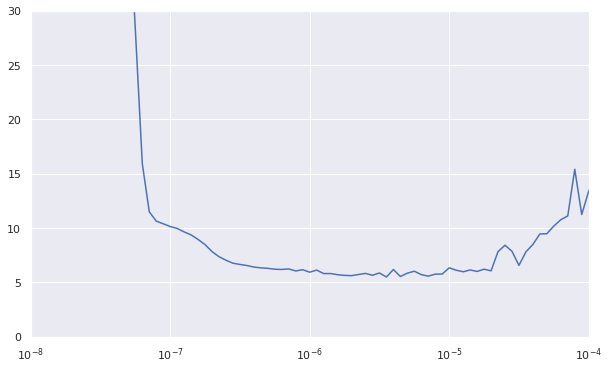

In [134]:
# Plot
# The y-axis shows the loss for that epoch and the x-axis shows us the learning rate
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
openfig()
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])


In [135]:
print(lrs[np.argmin(history.history['loss'])])

3.5481338923357534e-06


Lets create a second model, we will change the following things. First, we will have a larger batch size, now it will be 128. Second, we will decrease the learning rate. Third, now we increase the number of hidden units to 40. Finally, we also increase the number of epochs to 400.

In [0]:
# Second Model
t.manual_seed(1729)
np.random.seed(1729)

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size=128,
                           shuffle_buffer=shuffle_buffer_size)

In [138]:
model2 = Sequential(Net(hidden_size=40))
optimizer = optim.SGD(model2.model.parameters(), lr=5e-5, momentum=0.9)
model2.t_compile(loss=nn.SmoothL1Loss(), optimizer=optimizer, metric=mean_absolute_error)
history2 = model2.t_fit(dataset, epochs=400)

Finished Training


In [0]:
forecast2 = []
for time in range(len(series) - window_size):
    forecast_feature = series[time:time + window_size][np.newaxis]
    forecast2.append(model2.t_predict(t.from_numpy(forecast_feature)))

In [0]:
forecast2 = forecast2[:test_size-window_size]
results = t.cat(forecast2).detach().numpy()[:, 0]

We want to look now at our loss and MAE. We will plot them against the number of epochs.

In [0]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
mae = history2.history['mean_absolute_error']
loss = history2.history['loss']

epochs = range(len(loss))  # Get number of epochs

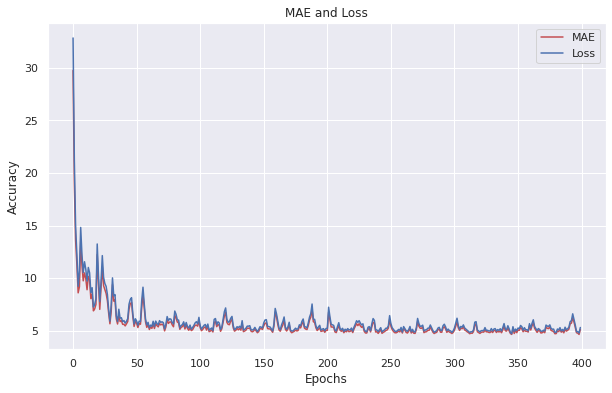

In [142]:
# Plot MAE and Loss
openfig()
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

Let's look more into the second half of the epochs. Looking at the first plot, one might believe that the number of epochs can be reduced to 200.

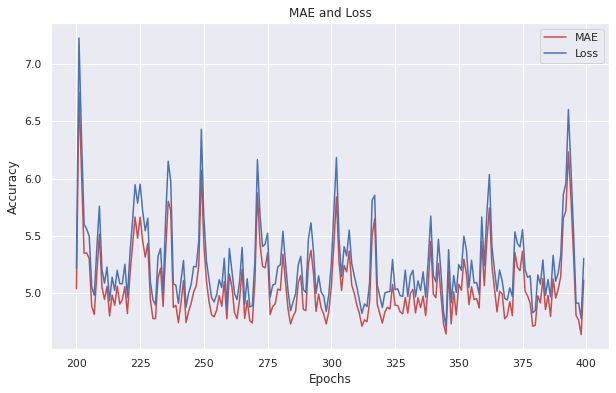

In [143]:
# Plot Zoomed MAE and Loss
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]
openfig()
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

We will do a third and last experiment, where we will reduce the learning rate, the number of units and the epochs.

In [0]:
# Experiment 3
t.manual_seed(1729)
np.random.seed(1729)

dataset3 = windowed_dataset(x_train, window_size, batch_size,
                            shuffle_buffer_size)

In [0]:
model3 = Sequential(Net(hidden_size=32))
model3.t_compile(loss=nn.MSELoss(),
                 optimizer=optim.SGD(model3.model.parameters(), lr=1e-6,
                                     momentum=0.9), metric=mean_absolute_error)

In [146]:
history3 = model3.t_fit(dataset3, epochs=100)

Finished Training


In [0]:
forecast3 = []
for time in range(len(series) - window_size):
    forecast_feature3 = series[time:time + window_size][np.newaxis]
    forecast3.append(model3.t_predict(t.from_numpy(forecast_feature3)))

Let's look at the obtained Mean Absolute Error and if this configuration is better than the previous one.

In [148]:
forecast3 = forecast3[split_time-window_size:]
results3 = t.cat(forecast3).detach().numpy()[:, 0]
print(mean_absolute_error(x_valid, results3))

5.9026318


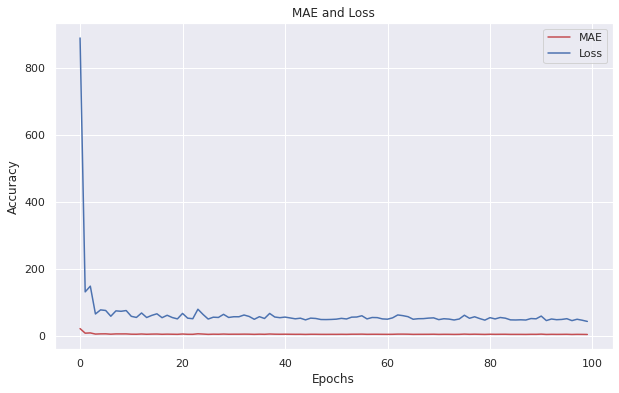

In [149]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
mae = history3.history['mean_absolute_error']
loss = history3.history['loss']

epochs = range(len(loss))  # Get number of epochs

# Plot MAE and Loss
openfig()
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])